# Setup

In [1]:
import sys
# sys.path.append("/kaggle/input/python-helpers/") # Comment this out when you are not in Kaggle kernel
sys.path.append("../") # Comment this out when you are in local environment
import utils
from utils import (
    # General Functions
    check_memory_usage, check_memory_by_global_variable, # For memory handling
    get_time_now, cprint, # For logging
    get_cols, downcast_to_32bit, my_concat, my_power, my_log, list_diff, # For preprocessing
    plot_feature_importance, plot_scatterplot, # For visualization
    get_feature_summary, # For feature engineering & feature selection
    check_auc, plot_heatmap, # For EDA
    # Competition Constants
    META_COLUMNS, 
    # Competition Functions
    percentile, 
    read_data, read_model, # Data Ingestion
    filter_df, check_target_dependency, # EDA
    feature_group_corr_calc, calculate_psi, run_chi_square_tests, # Validation
    train_lgbm, # Model Training
    clean_df, get_price_clippers, get_volume_clippers, clip_df, # Pre-processing: Clean & Clip
    calc_robust_scale, calc_std_scale, scale_base_columns,  # Pre-processing: Scaling
    increment_date_id, calc_diff_features, calc_ma_features, calc_interday_gradient_features, # Pre-processing: Feature Generation
    setup_validation_zip, # Simulation
    lgbm_inference_by_batch, # Inference
    zero_sum, # Post-processing
)
from utils import (
    calc_intraday_gradient
)

In [2]:
import gc
import joblib
import lightgbm as lgb
from lightgbm import LGBMRegressor, log_evaluation
import math
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False, nb_workers=12)
# import plotly.express as px
import random
import scipy.cluster.hierarchy as sch
import seaborn as sns
import time

import catboost
from catboost import CatBoostRegressor
from datetime import datetime
from itertools import combinations, groupby, product
from scipy.stats import pearsonr, chi2_contingency
from scipy.cluster.hierarchy import fcluster
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
tqdm.pandas()
from numba import njit, prange

import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [3]:
%load_ext autoreload
%autoreload

In [4]:
DATA_DIR = '../data/'

In [5]:
# Set this to 0 to re-run for generating all features E2E, and 240 or larger for testing new feature generation
START_DATE = 240

## Read Data

In [6]:
%%time
train = read_data(f'{DATA_DIR}/optiver-train-data/clipped_train.parquet')
weight_df = read_data(f"{DATA_DIR}/optiver-support-data/stock_weight.csv")

CPU times: total: 2.55 s
Wall time: 800 ms


In [7]:
train = filter_df(train, date_id=(START_DATE, 480), reset_index=True)

In [8]:
missing_stock_dates = read_data(f"{DATA_DIR}/optiver-preprocess-helpers/missing_stock_dates.pkl")
print(missing_stock_dates)

[(19, [438]), (73, [320]), (99, [138]), (101, [328]), (131, [35]), (158, [388])]


In [9]:
base_columns = sorted(get_cols(train, contains=["price", "size"]))
base_price_cols = get_cols(train, "price")
base_volume_cols = get_cols(train, "size")
target_columns = get_cols(train, "target")
subset_price_cols = ['ask_price', 'bid_price', 'wa_price', 'ref_price']
subset_price_cols2 = ['far_price', 'near_price', 'wa_price', 'ref_price']

# Cross-Sectional Features (Level 1)

In [10]:
LGBM_MODEL_VERSION = 9
lgbm_val_model_path = f'{DATA_DIR}/optiver-lgbm-models/lgbm_model{LGBM_MODEL_VERSION}_val.txt'
lgbm_val_data_path = f'{DATA_DIR}/optiver-lgbm-models/lgbm_model{LGBM_MODEL_VERSION}_val.csv'
lgbm_final_model_path = f'{DATA_DIR}/optiver-lgbm-models/lgbm_model{LGBM_MODEL_VERSION}.txt'

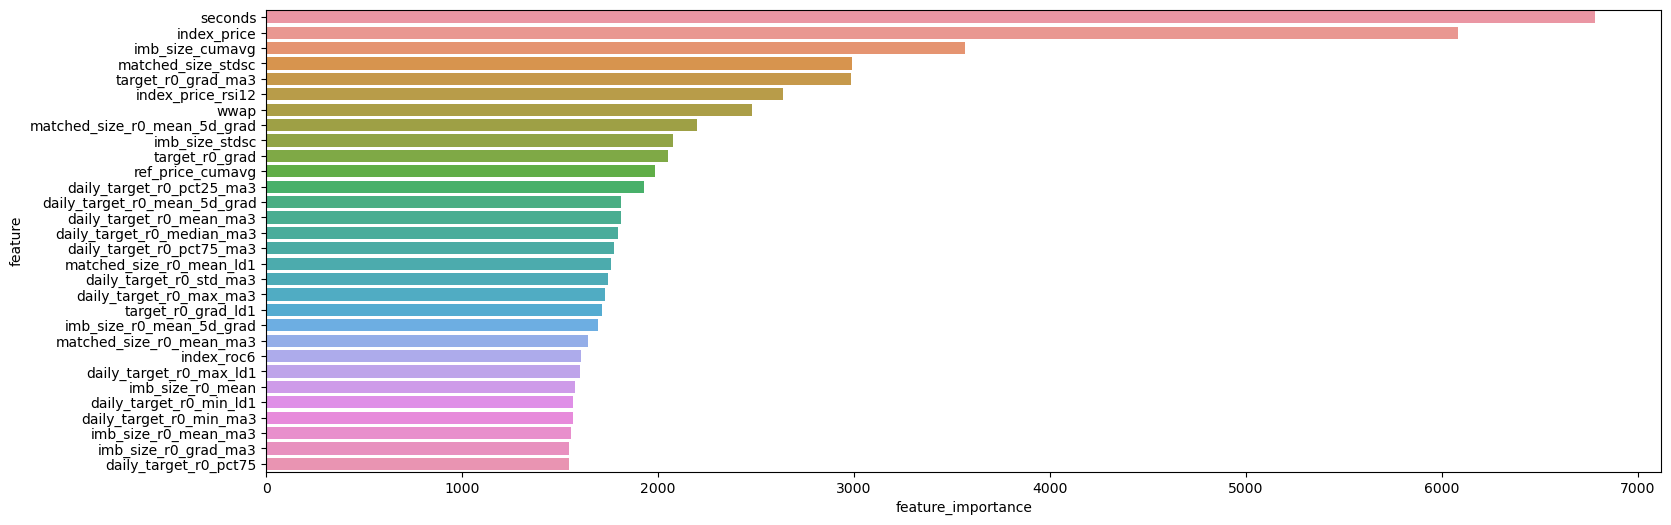

In [11]:
val_model = read_model(lgbm_val_model_path)
imp_df = plot_feature_importance(val_model.feature_name(), val_model.feature_importance(), return_df=True, limit=30, figsize=(18, 6))

In [12]:
#logp = read_data("../features_summary/features_logp_values.csv")

In [13]:
logp[get_cols(logp, endswith="gap", excludes="fod")].median().sort_values()

NameError: name 'logp' is not defined

In [14]:
imp_df.loc[imp_df["feature"].str.contains("(_kurt)$")]

,feature,feature_importance,feature_importance_rank
144,subset_prices2_kurt,786,134
305,subset_prices_kurt,182,275


In [15]:
imp_df.loc[imp_df["feature"].str.contains("(imb_ratio2)$")]

,feature,feature_importance,feature_importance_rank
193,abr_imb_ratio2,474,181
201,bim_imb_ratio2,435,188
209,aim_imb_ratio2,416,195
268,brw_imb_ratio2,264,245
295,arw_imb_ratio2,206,267
348,abm_imb_ratio2,96,310
352,abi_imb_ratio2,88,314


## Merge Weight

In [16]:
def merge_weight(df, weight_df, verbose=0):
    if "weight" not in df.columns:
        df = df.merge(weight_df, on=["stock_id"], how="left")
        df["wwap"] = df["weight"] * df["wa_price"]
    
    if verbose:
        cprint(f"Calculating index price...", color="green")
    if "index_price" not in df.columns:
        df = df.merge(
            df.groupby(["date_id", "seconds"])["wwap"].sum().rename("index_price"),
            left_on=["date_id", "seconds"],
            right_index=True
        )
        df["z_price"] = (1 + df["wa_price"] - df["index_price"])
        # df = df.sort_values(by=META_COLUMNS).reset_index(drop=True)
        
    return df

In [17]:
%%time
print(train.shape)
train = merge_weight(train, weight_df, verbose=1)
print(train.shape)

(2647755, 18)
Calculating index price...
(2647755, 22)
CPU times: total: 891 ms
Wall time: 1.12 s


In [18]:
train

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,ask_size,wa_price,target,clipped_target,is_positive_target,is_mild_target,weight,wwap,index_price,z_price
0,0,240,0,-3.693855e+06,-1,1.000361,1.355369e+07,NaN,NaN,0.999939,...,9498.000000,1.000000,-13.359785,-13.359785,0,0,0.004,0.004000,0.994000,1.006000
1,1,240,0,0.000000e+00,0,1.000221,8.244517e+05,NaN,NaN,0.999599,...,5310.250000,1.000000,12.099743,12.099743,1,0,0.001,0.001000,0.994000,1.006000
2,2,240,0,3.501658e+05,1,1.000012,2.068030e+06,NaN,NaN,0.998433,...,95.000000,1.000000,-15.389919,-15.389919,0,0,0.002,0.002000,0.994000,1.006000
3,3,240,0,-2.024017e+07,-1,1.000176,2.196303e+07,NaN,NaN,0.999766,...,17060.000000,1.000000,-4.860163,-4.860163,0,0,0.006,0.006000,0.994000,1.006000
4,4,240,0,-4.918696e+06,-1,1.000083,1.811757e+07,NaN,NaN,0.999874,...,5749.200195,1.000000,-1.220107,-1.220107,0,1,0.004,0.004000,0.994000,1.006000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2647750,195,480,540,-2.440723e+06,-1,1.000317,2.828036e+07,0.999734,0.999734,1.000317,...,319862.406250,1.000328,2.310276,2.310276,1,1,0.004,0.004001,0.998756,1.001572
2647751,196,480,540,-3.495105e+05,-1,1.000643,9.187699e+06,1.000129,1.000386,1.000643,...,93393.070312,1.000819,-8.220077,-8.220077,0,0,0.001,0.001001,0.998756,1.002063
2647752,197,480,540,0.000000e+00,0,0.995789,1.272544e+07,0.995789,0.995789,0.995789,...,180038.312500,0.995797,1.169443,1.169443,1,1,0.004,0.003983,0.998756,0.997041
2647753,198,480,540,1.000899e+06,1,0.999210,9.477327e+07,0.999210,0.999210,0.998970,...,669893.000000,0.999008,-1.540184,-1.540184,0,1,0.006,0.005994,0.998756,1.000252


## Price Column Interaction

In [20]:
@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices, imb_types=[1, 2, 3]):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imb_array_dict = {}
    for imb_type in imb_types:
        imb_array_dict[imb_type] = np.empty((num_rows, num_combinations))

    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        
        for j in range(num_rows):
            max_ = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_ = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_ = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_ - max_
            
            if 1 in imb_types:
                imb_array_dict[1][j, i] = (1 + max_ - mid_) / (1 + mid_ - min_)
          
            if 2 in imb_types:
                if max_ == min_:
                    imb_array_dict[2][j, i] = np.nan
                else:
                    imb_array_dict[2][j, i] = (mid_ - min_) / (max_ - min_)
            
            if 3 in imb_types:
                if mid_ != mid_:
                    imb_array_dict[3][j, i] = np.nan
                else:
                    imb_array_dict[3][j, i] = min_ / mid_
                    
            if 4 in imb_types:
                if max_ != max_:
                    imb_array_dict[4][j, i] = np.nan
                else:
                    imb_array_dict[4][j, i] = mid_ / max_
                    
    imbalance_features = [array for array in imb_array_dict.values()]
    return imbalance_features

# Function to calculate triplet imbalance for given price data and a DataFrame
def calculate_triplet_imbalance_numba(df, columns, imb_types, selected_prefixes=[]):
    # Convert DataFrame to numpy array for Numba compatibility
    df_values = df[columns].values
    comb_indices = []
    for a, b, c in combinations(columns, 3):
        triplet_col_prefix = "".join(sorted([col[0] for col in [a, b, c]]))
        if triplet_col_prefix in selected_prefixes or len(selected_prefixes) == 0:
            comb_indices.append((columns.index(a), columns.index(b), columns.index(c)))

    # Calculate the triplet imbalance using the Numba-optimized function
    features_array = compute_triplet_imbalance(df_values, comb_indices, imb_types=imb_types)
    features_array = np.hstack(features_array)
    
    # Create a DataFrame from the results
    final_columns, selected_columns = [], []
    for imb_type in imb_types:
        for triplet in combinations(columns, 3):
            triplet_col_prefix = "".join(sorted([col[0] for col in triplet]))
            col_name = f"{triplet_col_prefix}_imb_ratio{imb_type}"
            if triplet_col_prefix in selected_prefixes or len(selected_prefixes) == 0:
                selected_columns.append(col_name)
            
    features = pd.DataFrame(features_array, columns=selected_columns)
    return features

In [21]:
def generate_price_cross_sectional_features(train, base_price_cols, verbose=0):
    # Calculate the spread and midpoint for price pairs
    if verbose:
        cprint(f"Generating 2 price columns' interaction features...", color="green")
    for pair in tqdm(combinations(base_price_cols, 2), disable=not verbose):
        p_col1, p_col2 = pair
        first_letters = [col[0] for col in pair]
        pair_col_prefix = "".join(sorted(first_letters))
        
        # Price gap (bid-ask spread is ab_spread here, because the prefix is sorted by alphabet)
        if pair_col_prefix not in ["an", "bn", "af", "bf"]:
            train[f"{pair_col_prefix}_spread"] = train[p_col1] - train[p_col2]
        
        # Mid point of two prices
        if pair_col_prefix in ["nw", "fw", "fn", "rw"]:
            train[f"{pair_col_prefix}_mid"] = (train[p_col1] + train[p_col2]) / 2
    
    # Calculate the imbalance ratio for price triplets
    if verbose:
        cprint(f"Generating 3 price columns' interaction features...", color="green")
    triplet_feature = calculate_triplet_imbalance_numba(train, columns=base_price_cols, imb_types=[1, 3, 4], selected_prefixes=["abr", "brw", "abw", "arw", "fnw", "frw", "nrw"])
    train[triplet_feature.columns] = triplet_feature.values
    
    triplet_feature = calculate_triplet_imbalance_numba(train, columns=base_price_cols, imb_types=[2], selected_prefixes=[])
    train[triplet_feature.columns] = triplet_feature.values
    
    # Calculate the agg stats for price quartets
    if verbose:
        cprint(f"Generating 4 price columns' interaction features...", color="green")
    for quartet in tqdm(combinations(base_price_cols, 4), disable=not verbose):
        first_letters = [col[0] for col in quartet]
        quad_col_prefix = "".join(sorted(first_letters))
        for func in ["skew", "kurt"]:
            train[f"{quad_col_prefix}_{func}"] = train[list(quartet)].agg(func, axis=1)
            
        if quad_col_prefix not in ["abfw", "abnw", "fnrw", "abrw"]:
            continue

        for func in ["mean", "std"]:
            train[f"{quad_col_prefix}_{func}"] = train[list(quartet)].agg(func, axis=1)

    return train

In [22]:
%%time
print(train.shape)
train = generate_price_cross_sectional_features(train, base_price_cols=base_price_cols, verbose=1)
print(train.shape)

(2647755, 22)
Generating 2 price columns' interaction features...


15it [00:00, 44.08it/s]


Generating 3 price columns' interaction features...
Generating 4 price columns' interaction features...


15it [00:48,  3.26s/it]

(2647755, 116)
CPU times: total: 1min 56s
Wall time: 1min 11s


In [ ]:
pd.Series(my_log(train["ab_spread"])).plot.hist(bins=100)

In [ ]:
# train[["temp", "clipped_target"]].corr()

In [ ]:
# a = train[["temp", "clipped_target"]].dropna()
# plot_scatterplot(a, x_col=a.columns[0], y_col=a.columns[1])

## Volume Column Interaction

In [ ]:
def generate_volume_cross_sectional_features(train, base_vol_cols, verbose=0):
    # Generate features using bid and ask size
    train["c_size"] = train["ask_size"] + train["bid_size"]
    train["c_size_gap"] = train["ask_size"] - train["bid_size"]
    train["c_gt_ratio"] = train["c_size_gap"] / train["c_size"]
    
    # imb_size be the first one to avoid divided by zero
    final_base_vol_cols = ["imb_size", "matched_size", "c_size"]
    
    if verbose:
        cprint(f"Generating 2 volumes (or log volume) columns' interaction features...", color="green")
    for v_col1, v_col2 in tqdm(combinations(final_base_vol_cols, 2), disable=not verbose):
        paired_col = "".join(sorted([v_col1[0], v_col2[0]]))
        
        train[f"{paired_col}_size_gap"] = train[v_col1] - train[v_col2]
        train[f"{paired_col}_gt_ratio"] = train[f"{paired_col}_size_gap"] / (train[v_col1] + train[v_col2])
        
        train[f"{paired_col}_size_ratio"] = train[v_col1] / train[v_col2]
        
    if verbose:
        cprint(f"Generating 3 volumes (or log volume) columns' interaction features...", color="green")
    train["jmb_size"] = train["imb_size"] + train["imb_flag"]
    triplet_feature = calculate_triplet_imbalance_numba(train, columns=["c_size", "jmb_size", "matched_size"], imb_types=[2, 3, 4])
    train[triplet_feature.columns] = triplet_feature.values
    
    return train

In [ ]:
%%time
print(train.shape)
train = generate_volume_cross_sectional_features(train, base_vol_cols=base_volume_cols, verbose=1)
print(train.shape)

## Price Volume Interaction

**Feature Name Mapping**
- liquidity_imbalance => ab_gt_ratio
- depth_pressure => fn_depth_pressure
- price_pressure => ab_imb_price_pressure

In [ ]:
price_columns = get_cols(train, endswith="price")
spread_columns = ["rw_spread", "aw_spread", "bw_spread", "ab_spread", "fn_spread"]
size_columns = ["ask_size", "bid_size", "c_size", "matched_size", "imb_size"]
size_columns2 = ["c_size", "matched_size", "imb_size"]
size_gap_columns = ['c_size_gap', 'im_size_gap', 'ci_size_gap', 'cm_size_gap']
gt_ratio_columns = ["c_gt_ratio", 'im_gt_ratio', 'ci_gt_ratio', 'cm_gt_ratio']

In [ ]:
def generate_price_volume_cross_sectional_features(train, verbose=0):
    if verbose:
        cprint(f"Generating price-volume interaction features...", color="green")
    
    for price, size in tqdm(product(price_columns, size_columns), disable=not verbose):
        prefix = price[0] + size[0]
        if prefix in ["aa", "bb", "rm", "wi"]:
            train[f"{prefix}_product"] = train[price] * train[size]
    
    for spread, size in tqdm(product(spread_columns, size_columns), disable=not verbose):
        prefix = spread[:2] + size[0]
        train[f"{prefix}_price_pressure"] = train[spread] * train[size]
        
    for spread, size_gap in tqdm(product(spread_columns, size_gap_columns), disable=not verbose):
        prefix = spread[:2] + size_gap.replace("_size_gap", "")
        train[f"{prefix}_depth_pressure"] = train[spread] * train[size_gap]
    
    for spread, gt_ratio in tqdm(product(spread_columns, gt_ratio_columns), disable=not verbose):
        prefix = spread[:2] + gt_ratio.replace("_gt_ratio", "")
        train[f"{prefix}_market_urgency"] = train[spread] * train[gt_ratio]
    
    # for suffix in ["_product", "_price_pressure", "_depth_pressure", "_market_urgency"]:
    #     for col1, col2 in tqdm(combinations(get_cols(train, endswith=suffix), 2), disable=not verbose):
    #         c1 = col1.replace(suffix, "")
    #         c2 = col2.replace(suffix, "")
    #         train[f"{c1}_{c2}{suffix}_sp_ratio"] = (train[col1] - train[col2]) / (train[col1] + train[col2])
    
    return train

In [ ]:
%%time
print(train.shape)
train = generate_price_volume_cross_sectional_features(train)
print(train.shape)

In [ ]:
train = downcast_to_32bit(train)

In [ ]:
# corr_df = feature_group_corr_calc(train, columns=get_cols(train, endswith=["_price_pressure_sp_ratio"]), cluster_thresh=2)

In [ ]:
# corr_df

In [ ]:
# plot_scatterplot(train, x_col="abw_imb_ratio1", y_col="abw_imb_ratio2")

In [ ]:
# plot_heatmap(
#     corr_df,
#     annot=True,
#     fmt=".2f",
#     figsize=(23, 22)
# )

# Intraday (Temporal) Features

## Revealed Target, up to T - 60; Market (Index) Return & Stock Return (in WAP) up to T - 10

In [ ]:
def generate_intraday_leaked_target_features(df, windows=[1, 2, 3, 4, 5, 6], verbose=0):
    if verbose:
        cprint(f"Sorting dataframe...", color="green")
    df = df.sort_values(by=META_COLUMNS).reset_index(drop=True)
    
    if verbose:
        cprint(f"Generating lag return...", color="green")
    for window in tqdm(windows, disable=not verbose):
        df[f"index_price_roc{window}"] = df.groupby(["stock_id", "date_id"])["index_price"].pct_change(window).values
        df[f"wa_price_roc{window}"] = df.groupby(["stock_id", "date_id"])["wa_price"].pct_change(window).values

        # Previously I was using 1 + df.groupby(["stock_id", "date_id"])["target"].shift(6) / 10000
        df[f"return_l{window}"] = (df[f"wa_price_roc{window}"] - df[f"index_price_roc{window}"]) * 10000
        df[f"return_l{window}_fod"] = df.groupby(["stock_id", "date_id"])[f"return_l{window}"].diff(1).values
        
        df[f"return_l{window}_ma3"] = df.groupby(["stock_id", "date_id"])[f"return_l{window}"].rolling(3).mean().values
        
    df["intraday_cumsum_return_l1"] = df.groupby(["stock_id", "date_id"])["return_l1"].cumsum()
    df["intraday_cumavg_return_l1"] = df["intraday_cumsum_return_l1"] / (df["seconds"] / 10 + 1)

    return df

In [ ]:
%%time
print(train.shape)
train = generate_intraday_leaked_target_features(train, verbose=1)
print(train.shape)

In [ ]:
plot_heatmap(
    train.loc[:, get_cols(train, contains=["return", "index_price_roc", "wa_price_roc"]) + ["clipped_target"]].corr(),
    annot=True,
    fmt=".2f",
    figsize=(21, 19)
)

## First Order Difference

In [ ]:
def calc_fod(df, fod_columns, groupby=["stock_id", "date_id"], verbose=0):
    if verbose:
        cprint(f"Constructing First Order Diff Features...", color="blue")
    fod_df = df.groupby(groupby)[fod_columns].diff(1).add_suffix("_fod")
    for col in tqdm(fod_df.columns, disable=not verbose):
        if col not in df.columns:
            df[col] = fod_df[col]
    
    final_fod_columns = fod_df.columns.tolist()
    
    if verbose:
        cprint(f"Calculating Cumulative Averages...", color="blue")
    final_fod_df = df.groupby(groupby)[final_fod_columns].cumsum()
    
    for col in tqdm(final_fod_df.columns, disable=not verbose):
        new_col = col.replace("_fod", "_cumavg")
        # Convert seconds to count, 0 => 1, 10 => 2, 20 => 3, ... 540 => 55
        if new_col not in df.columns:
            df[new_col] = final_fod_df[col] / (df["seconds"] / 10 + 1)
    
    if verbose:
        cprint(f"Calculating FOD spread & sum...", color="blue")
    if len(final_fod_columns) >= 2:
        for col1, col2 in tqdm(combinations(final_fod_columns, 2), disable=not verbose):
            c1 = col1.replace("_fod", "")
            c2 = col2.replace("_fod", "")
            prefix = f"{c1}_{c2}"
            df[f"{prefix}_fod_spread"] = df[col1] - df[col2]
            df[f"{prefix}_fod_sum"] = df[col1] + df[col2]
            df[f"{prefix}_fod_ratio"] = df[col1] / df[col2]
            df[f"{prefix}_fod_ratio"] = df[f"{prefix}_fod_ratio"].clip(-2, 2)
            
    return df

In [ ]:
def generate_fod_columns(df, fod_column_list, verbose=0):
    if verbose:
        cprint(f"Sorting DataFrame based on {META_COLUMNS}... (So that the rolling features is correct)", color="blue")
    df = df.sort_values(by=META_COLUMNS).reset_index(drop=True)
    
    for fod_columns in fod_column_list:
        if verbose:
            print(train.shape)
            cprint(f"For {fod_columns}:", color="green")
            
        df = calc_fod(df, fod_columns=fod_columns, verbose=verbose)
    
    return df

In [ ]:
%%time
print(train.shape)
train = generate_fod_columns(train, fod_column_list=[subset_price_cols, base_volume_cols + ["c_size"]])
print(train.shape)

In [ ]:
train = downcast_to_32bit(train)

## Rate of Change

In [ ]:
def generate_roc_columns(df, columns, groupby=["stock_id", "date_id"], r=1, verbose=0):
    df = df.sort_values(by=META_COLUMNS).reset_index(drop=True)
    
    if verbose:
        cprint(f"Constructing Rate of Change Features...", color="blue")
        
    suffix = f"_roc{r}"
    roc_df = df.groupby(groupby)[columns].pct_change(r).add_suffix(suffix)
    for col in tqdm(roc_df.columns, disable=not verbose):
        if col not in df.columns:
            df[col] = roc_df[col]
    
    final_roc_columns = roc_df.columns
    
    if verbose:
        cprint(f"Calculating Cumulative Products...", color="blue")
    final_roc_df = df.groupby(groupby)[final_roc_columns].cumprod()
    
    suffix2 = f"_s_ratio{r}"
    for col in tqdm(final_roc_df.columns, disable=not verbose):
        new_col = col.replace(suffix, suffix2)
        if new_col not in df.columns:
            df[new_col] = final_roc_df[col] / (df["seconds"] / 10 + 1)
    
    return df

In [ ]:
%%time
print(train.shape)
train = generate_roc_columns(train, columns=base_price_cols + base_volume_cols + ["wwap", "z_price"])
print(train.shape)

In [ ]:
train = downcast_to_32bit(train)

## Lag Features

In [ ]:
def generate_lag_columns(df, columns, groupby=["stock_id", "date_id"], windows=[1, 2, 3, 4, 5], verbose=0):
    df = df.sort_values(by=META_COLUMNS).reset_index(drop=True)
    
    if verbose:
        cprint(f"Constructing Lag Features...", color="blue")
    for col in tqdm(columns, disable=not verbose):
        for window in windows:
            df[f"{col}_lag{window}"] = df.groupby(groupby)[col].shift(window)
    return df

In [ ]:
%%time
print(train.shape)
train = generate_lag_columns(train, columns=['matched_size', 'imb_size', 'wa_price', 'index_price', 'z_price', 'ref_price', 'imb_flag'], verbose=1)
print(train.shape)

## Market Indicator Features
- Moving Averages: Moving averages, such as the simple moving average (SMA) and exponential moving average (EMA), are used to identify trends. 
- A common buy signal is when a short-term moving average crosses above a longer-term moving average, indicating an uptrend.

### Relative Strength Index, RSI

In [ ]:
def calc_intraday_rsi(train, price_cols=["wa_price", "index_price", "z_price"], periods=[3, 6, 9, 18, 30], verbose=0):
    if verbose:
        cprint(f"Generating RSI features for column...", color="green")
    for price_col in tqdm(price_cols, disable=not verbose):
        for period in periods:
            price_roc_col = f"{price_col}_roc1" 
            train["temp_gain"] = np.where(train[price_roc_col] > 0, train[price_roc_col], 0)
            train["temp_loss"] = np.where(train[price_roc_col] < 0, -train[price_roc_col], 0)

            avg_loss = train.groupby(['stock_id', 'date_id'])["temp_loss"].rolling(period).mean().values
            avg_gain = train.groupby(['stock_id', 'date_id'])["temp_gain"].rolling(period).mean().values

            rsi_col = f"{price_col}_rsi{period}"
            train[rsi_col] = (1 - 1 / (1 + avg_gain / avg_loss))
            
            train[f"{rsi_col}_signal"] = np.where(
                train[rsi_col] > 0.7, -1, 
                np.where(
                    train[rsi_col] < 0.3, 
                    1, 
                    np.where(
                        train[rsi_col].between(0.3, 0.7),
                        0,
                        np.nan
                    )
                )
            )
        
    train.drop(columns=["temp_gain", "temp_loss"], inplace=True)
    return train

In [ ]:
%%time
print(train.shape)
train = calc_intraday_rsi(train, verbose=1)
print(train.shape)

In [ ]:
plot_heatmap(
    train[get_cols(train, contains=["rsi"], excludes=["signal"]) + ["clipped_target"]].corr(),
    annot=True,
    fmt=".2f"
)

### Moving Average Convergence/Divergence indicator, MACD

In [ ]:
def calc_intraday_macd(train, price_cols=["wa_price", "index_price", "z_price"], short_windows=[3, 6, 12], long_windows=[7, 13, 26], signal_windows=[2, 5, 9], verbose=0):
    if verbose:
        cprint(f"Generating MACD features for column...", color="green")
    for price_col in tqdm(price_cols, disable=not verbose):
        for sw, lw, signal_w in zip(short_windows, long_windows, signal_windows):
            short_ema = train.groupby(['stock_id', 'date_id'])[price_col].ewm(span=sw, adjust=False).mean().values
            long_ema = train.groupby(['stock_id', 'date_id'])[price_col].ewm(span=lw, adjust=False).mean().values

            macd_col = f"{price_col}_macd_{sw}_{lw}"
            train[macd_col] = (short_ema - long_ema)
            signal_line = train.groupby(['stock_id', 'date_id'])[macd_col].ewm(span=signal_w, adjust=False).mean().values
            
            macd_diff_col = macd_col + "_diff"
            train[macd_diff_col] = train[macd_col] - signal_line
            
            # Below signal line is overbought, Above is oversold
            upper_bound = 1.5e-5
            lower_bound = -1.5e-5
            
            train[f'{macd_col}_signal'] = np.where(
                train[macd_diff_col] > upper_bound, 
                1,
                np.where(
                    train[macd_diff_col] < lower_bound, 
                    -1,
                    np.where(
                        train[macd_diff_col].between(lower_bound, upper_bound),
                        0,
                        np.nan
                    )
                )
            )
    return train

In [ ]:
%%time
print(train.shape)
train = calc_intraday_macd(train)
print(train.shape)

In [ ]:
train["wa_price_macd_12_26_signal"].value_counts(normalize=True)

In [ ]:
plot_heatmap(
    train[get_cols(train, contains=["macd"], excludes=["signal"]) + ["clipped_target"]].corr(),
    annot=True,
    fmt=".2f"
)

### Bollinger Bands

In [ ]:
def calc_intraday_bollinger_bands(train, price_cols=["wa_price", "index_price", "z_price"], band_std=2, windows=[4, 11, 18, 26], verbose=0):
    if verbose:
        cprint(f"Generating Bollinger-Band features for column...", color="green")
    for price_col in tqdm(price_cols, disable=not verbose):
        for window in windows:
            rolling_window = train.groupby(['stock_id', 'date_id'])[price_col].rolling(window=window)
            rolling_mean = rolling_window.mean().values
            rolling_std = rolling_window.std().values

            upper_band = rolling_mean + (band_std * rolling_std)
            lower_band = rolling_mean - (band_std * rolling_std)

            # Above upper Bollinger is overbought, lower means oversold
            train[f'{price_col}_bollinger{window}_{band_std}udist'] = train[price_col] - upper_band
            train[f'{price_col}_bollinger{window}_{band_std}ldist'] = lower_band - train[price_col]                              
    return train

In [ ]:
%%time
print(train.shape)
train = calc_intraday_bollinger_bands(train, band_std=2, windows=[4, 11, 18, 26], verbose=1)
print(train.shape)

In [ ]:
plot_heatmap(
    train[get_cols(train, contains=["bollinger"], excludes=["signal"]) + ["clipped_target"]].corr(),
    annot=True,
    fmt=".2f"
)

# LZ Section

## volume_related_ratio

In [19]:
def generate_volume_ratio(df, group=['date_id','seconds_in_bucket'], 
                          size_cols = ["matched_size", "bid_size", "ask_size", "imb_size"],
                          windows=[2, 3, 4, 5, 6] , verbose=0):
    if verbose:
        cprint(f"Generating size related features for column...", color="green")
    for size in tqdm(size_cols, disable=not verbose):
        #calculate the volume to market volume at specific time period
        df[f'market_{size}'] = df.groupby(group)[size].transform('sum')
        df[f'{size}_to_market_ratio'] = df[size] / df[f'market_{size}']
        df = df.drop(f'market_{size}',axis=1)
    
        #caculate the relative size at different window
        for window in windows:
            df[f'{size}_ma{window}'] = df.groupby(['stock_id','date_id'])[size].rolling(window=window).mean().values
            df[f'relative_{size}_ma{window}'] = df[size] / df[f'{size}_ma{window}']
            
            #Previous day average size
            df[f'prev_day_avg_{size}'] = df.groupby(['stock_id','date_id'])[size].transform('mean')
            df[f'prev_day_avg_{size}'] =  df.groupby('stock_id')[f'prev_day_avg_{size}'].shift(55)
            df[f'today_to_ytd_{size}_ratio'] = df[size] / df[f'prev_day_avg_{size}'] 
            df = df.drop(f'prev_day_avg_{size}', axis=1)
    
    return df


In [20]:
%%time
print(train.shape)
train = generate_volume_ratio(train, group=['date_id','seconds'], size_cols = base_volume_cols, windows = [2, 3, 4, 5, 6], verbose=1)
print(train.shape)

(2647755, 22)
Generating size related features for column...


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:22<00:00, 35.54s/it]

(2647755, 70)
CPU times: total: 1min 48s
Wall time: 2min 22s


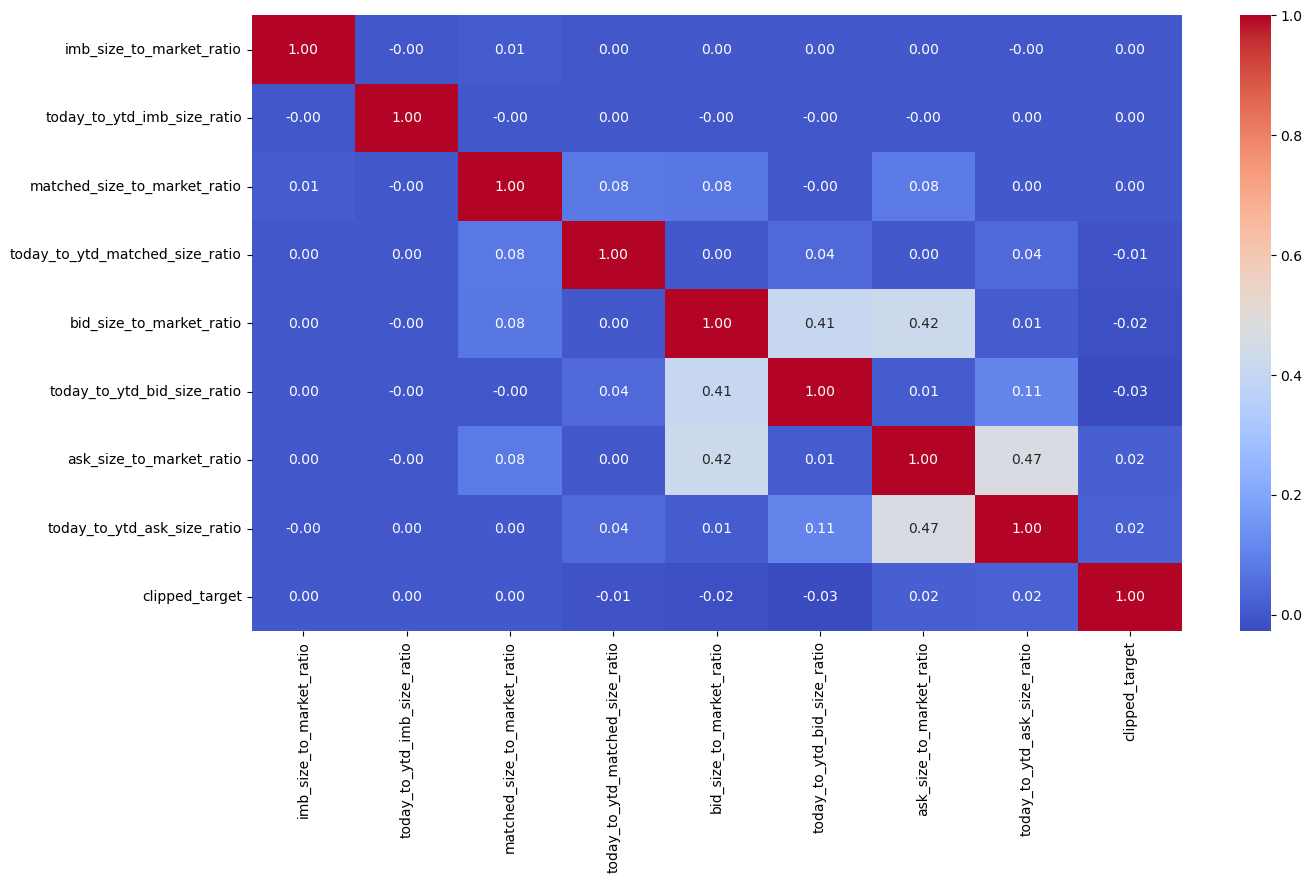

In [21]:
plot_heatmap(
    train[get_cols(train, contains=["ratio"], excludes=["ratio2"]) + ["clipped_target"]].corr(),
    annot=True,
    fmt=".2f"
)

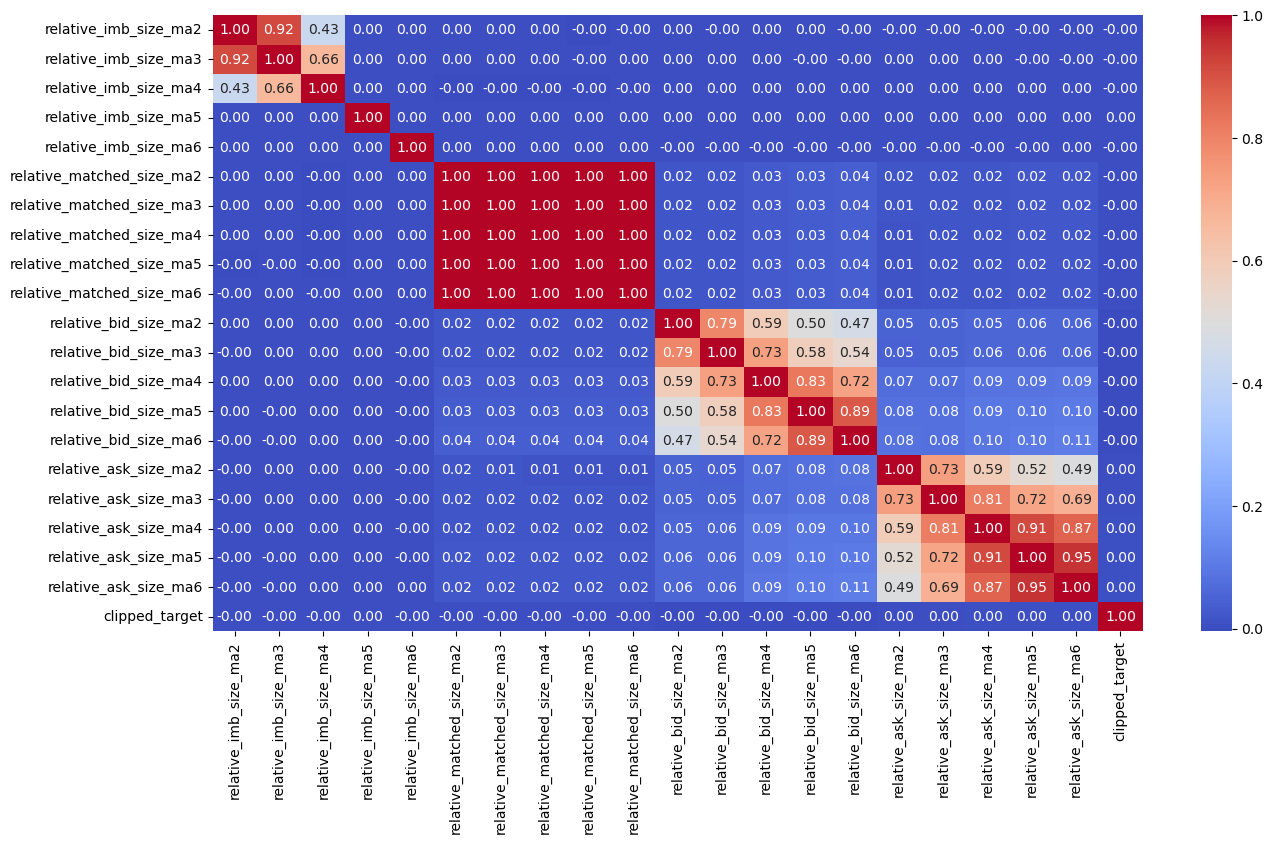

In [22]:
plot_heatmap(
    train[get_cols(train, contains=["relative"]) + ["clipped_target"]].corr(),
    annot=True,
    fmt=".2f"
)

## Hull Moving Average 

In [23]:
def calc_intraday_hma(df, group=['stock_id','date_id'], 
                      price_cols=["wa_price", "ask_price", "bid_price", "ref_price"], 
                      windows=[4,6,8,10,12], verbose=0):
    if verbose:
        cprint(f"Generating Hull Moving Average related features for column...", color="green")
    for price in tqdm(price_cols, disable=not verbose):
        for window in windows:
            weighted_moving_avg = df.groupby(group)[price].rolling(window=window).mean().values
            half_period_wma = df.groupby(group)[price].rolling(window= window//2).mean()

            sqrt_period = int(window** 0.5)

            half_period_wma_sqrt = half_period_wma.rolling(window=sqrt_period).mean().values

            df[f'{price}_hma{window}'] = 2 * half_period_wma_sqrt - weighted_moving_avg
    return df

In [24]:
%%time
print(train.shape)
train = calc_intraday_hma(train, group=['stock_id','date_id'], 
                          price_cols=["wa_price", "ask_price", "bid_price", "ref_price", "index_price", "z_price"],
                          windows=[4,6,8,10,12] , verbose=0)
    
print(train.shape)

(2647755, 70)
(2647755, 100)
CPU times: total: 4min 53s
Wall time: 5min 45s


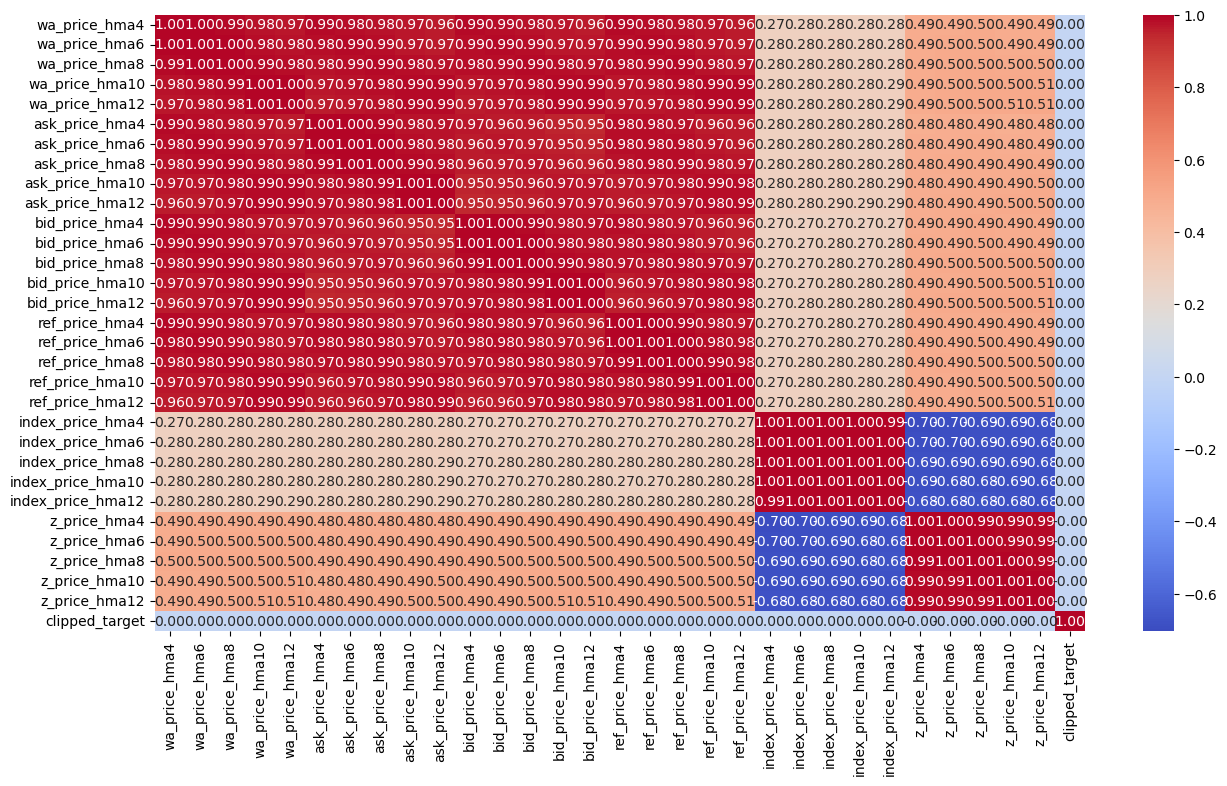

In [25]:
plot_heatmap(
    train[get_cols(train, contains=["hma"]) + ["clipped_target"]].corr(),
    annot=True,
    fmt=".2f"
)

## Relative Vigor Index

In [28]:
def calc_intraday_rvi(df, group = ['stock_id','date_id'], price_cols=["wa_price", "index_price", "z_price"],
                      windows = [3, 6, 9, 12, 15, 18, 21], verbose = 0):
    if verbose:
        cprint(f"Generating RVI features for column...", color="green")
    for price in price_cols:
        df[f'b{price[0]}_spread'] = df[price] - df['bid_price']
        df[f'a{price[0]}_spread'] = df['ask_price'] - df[price]

        df[f'{price[0]}_rvi'] = df[f'b{price[0]}_spread'] / df[f'a{price[0]}_spread']
        for window in windows:
            df[f'{price[0]}_rvi_smoothed_ma{window}'] = df.groupby(group)[f'{price[0]}_rvi'].rolling(window=window).mean().values
        df = df.drop([f'b{price[0]}_spread',f'a{price[0]}_spread'], axis=1)
    return df

In [29]:
%%time
print(train.shape)
train = calc_intraday_rvi(train, group = ['stock_id','date_id'], windows = [3, 6, 9, 12], verbose = 0)
print(train.shape)

(2647755, 103)
(2647755, 115)
CPU times: total: 54.6 s
Wall time: 1min 16s


Seems like WA_price rvi is useful only

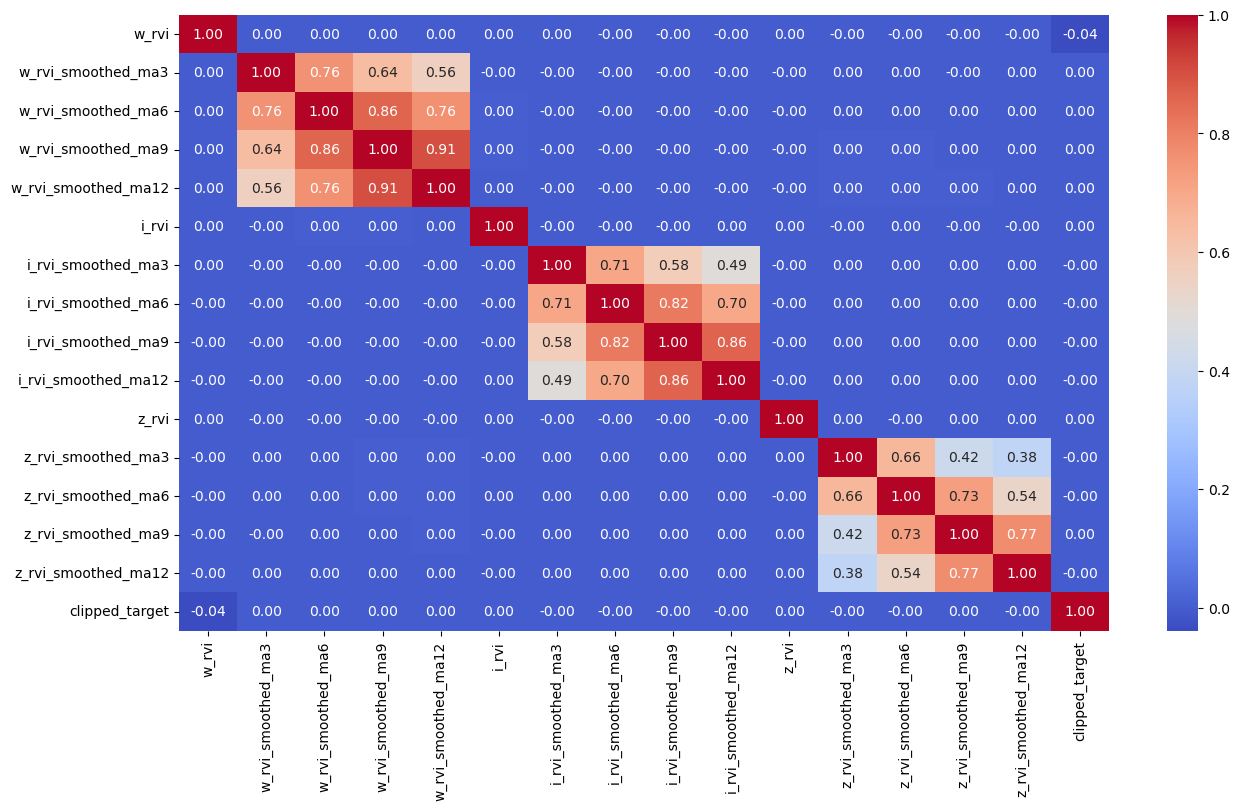

In [30]:
plot_heatmap(
    train[get_cols(train, contains=["rvi"]) + ["clipped_target"]].corr(),
    annot=True,
    fmt=".2f"
)

## Percentage Price Oscillator (PPO)

can combine with MACD but seems like no correlation

In [31]:
#calculate the moving average convergence divergence
def calc_intraday_ppo(df, price_cols=["wa_price", "index_price", "z_price"],  
                   short_windows=[3, 6, 12], long_windows=[7, 13, 26], signal_windows=[2, 5, 9], verbose = 0):
    if verbose:
        cprint(f"Generating PPO features for column...", color="green")
    for price_col in tqdm(price_cols, disable=not verbose):
        for sw, lw, signal_w in zip(short_windows, long_windows, signal_windows):
            short_ema = df.groupby(['stock_id','date_id'])[price_col].ewm(span=sw, adjust=False).mean().values
            long_ema = df.groupby(['stock_id','date_id'])[price_col].ewm(span=lw, adjust=False).mean().values

            ppo_col = f"{price_col}_ppo_{sw}_{lw}"
            df[ppo_col] = ((short_ema - long_ema) / long_ema) * 100
            signal_line = df.groupby(['stock_id', 'date_id'])[ppo_col].ewm(span=signal_w, adjust=False).mean().values
            df[f'{ppo_col}_signal'] = signal_line
            
            ppo_diff_col = ppo_col + "_diff"
            df[ppo_diff_col] = df[ppo_col] - signal_line
            
            # Below signal line is overbought, Above is oversold
            upper_bound = 1.5e-5
            lower_bound = -1.5e-5
            
            df[f'{ppo_col}_signal'] = np.where(
                df[ppo_diff_col] > upper_bound, 
                1,
                np.where(
                    df[ppo_diff_col] < lower_bound, 
                    -1,
                    np.where(
                        df[ppo_diff_col].between(lower_bound, upper_bound),
                        0,
                        np.nan
                    )
                )
            )

            
    return df

In [32]:
%%time
print(train.shape)
train = calc_intraday_ppo(train)
print(train.shape)

(2647755, 115)
(2647755, 142)
CPU times: total: 1min 5s
Wall time: 1min 29s


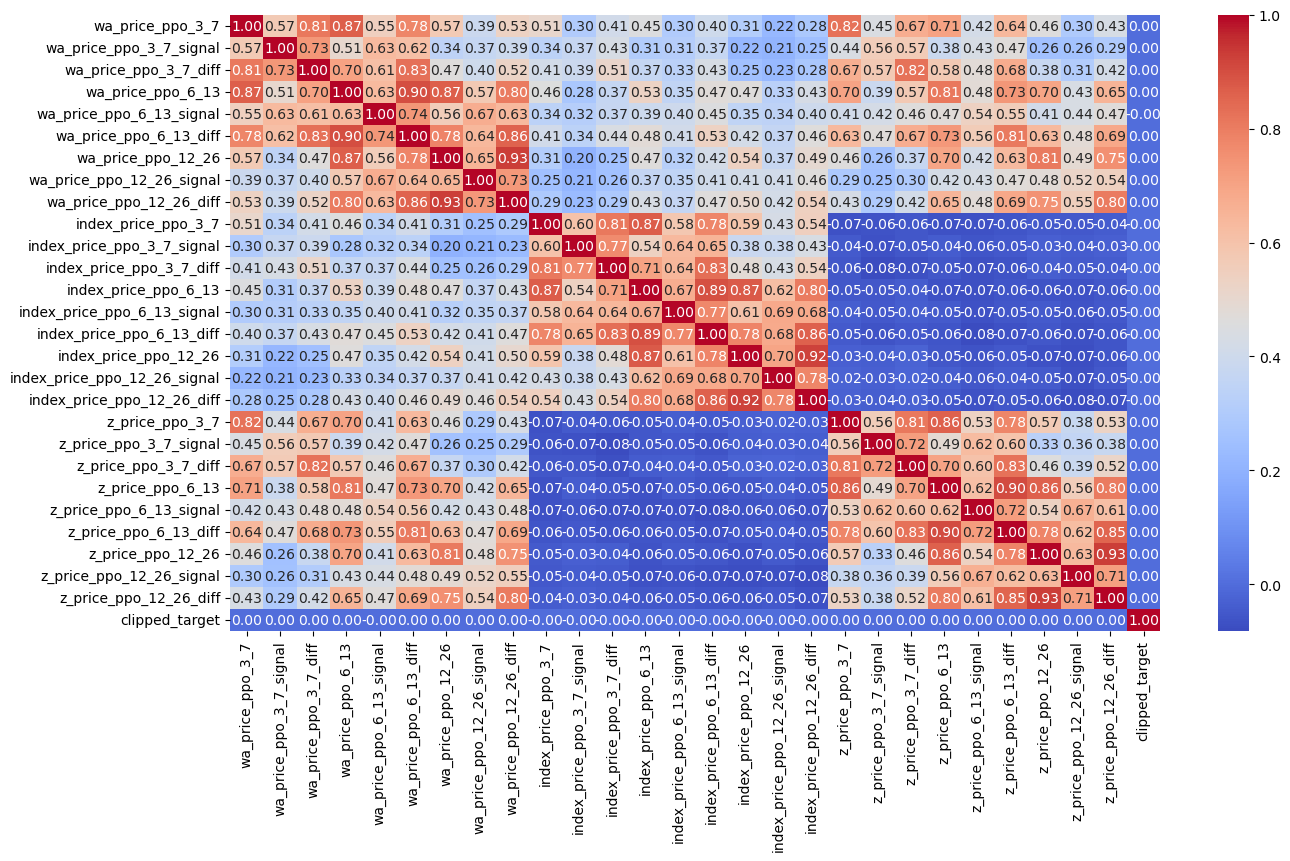

In [33]:
plot_heatmap(
    train[get_cols(train, contains=["ppo"]) + ["clipped_target"]].corr(),
    annot=True,
    fmt=".2f"
)

## Detrended Price Oscillator (DPO)

In [34]:
def calc_intraday_dpo(df, price_cols=["wa_price", "index_price", "z_price"],
                      windows = [3, 6, 9, 12], verbose = 0):
    if verbose:
        cprint(f"Generating DPO related features for column...", color="green")    
    # Calculate the displaced moving average
    for price_col in tqdm(price_cols, disable= not verbose):
        for window in windows:
            df[f'{price_col[0]}_displaced_ma{window}'] = df.groupby(['stock_id','date_id'])[price_col].shift(int(window / 2) + 1).rolling(window=window).mean().values

            # Calculate the Detrended Price Oscillator
            df[f'{price_col[0]}_dpo_ma{window}'] = df[price_col] - df[f'{price_col[0]}_displaced_ma{window}']

    return df

In [35]:
%%time
print(train.shape)
train = calc_intraday_dpo(train)
print(train.shape)

(2647755, 142)
(2647755, 166)
CPU times: total: 4.19 s
Wall time: 5 s


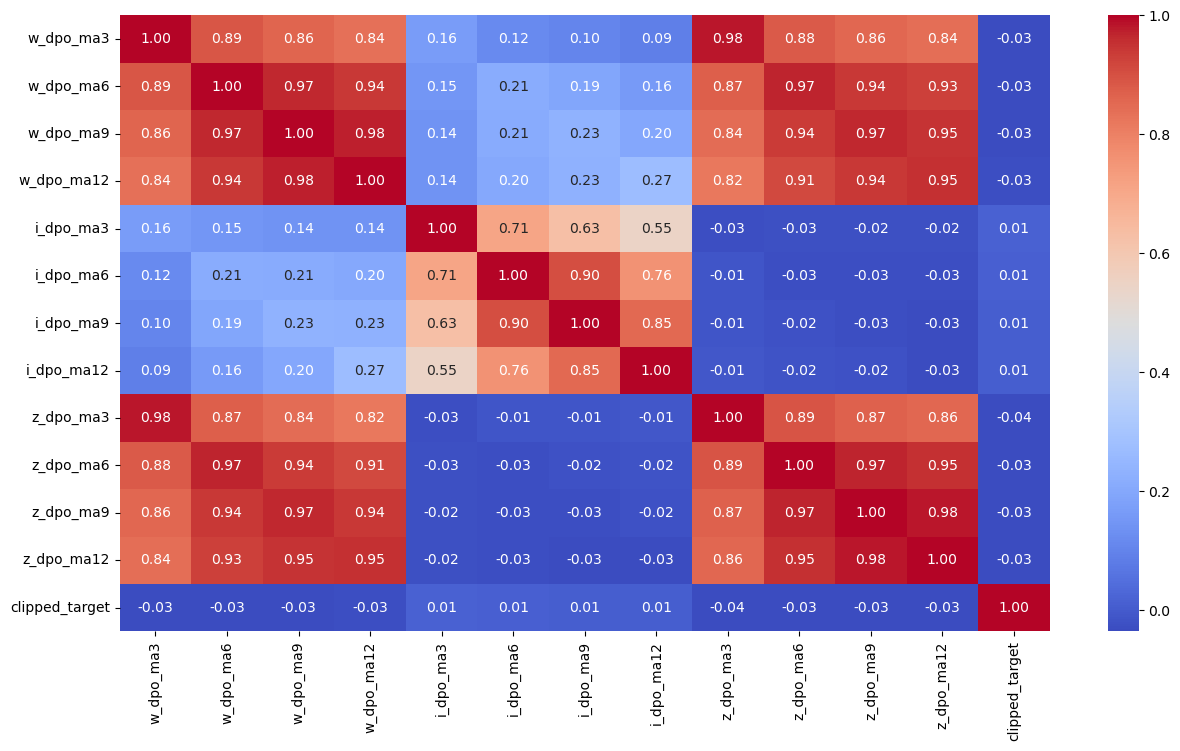

In [36]:
plot_heatmap(
    train[get_cols(train, contains=["dpo"]) + ["clipped_target"]].corr(),
    annot=True,
    fmt=".2f"
)

## Balance of Power (BOP) - take very long to run

In [37]:
def calc_intraday_bop(df, price_cols=["wa_price", "index_price", "z_price"], verbose = 0):
    if verbose:
        cprint(f"Generating BOP related features for column...", color="green")   
        
    # Calculate the displaced moving average
    for price_col in tqdm(price_cols, disable= not verbose):
        # Group by 'stock_id' and 'date_id'
        grouped_df = df.groupby(['stock_id', 'date_id'])

        # Iterate over the groups
        for name, group in grouped_df:
            # Calculate BPO for the current group
            group[f'{price_col[0]}_bop'] = (group[price_col] - group[price_col].shift(-1)) / (group['ask_price'] - group['bid_price'])

            # Update the original DataFrame with the calculated BPO values for the current group
            df.loc[group.index, f'{price_col[0]}_bop'] = group[f'{price_col[0]}_bop']
    return df

In [38]:
%%time
print(train.shape)
train = calc_intraday_bop(train)
print(train.shape)

(2647755, 166)
(2647755, 169)
CPU times: total: 4min 43s
Wall time: 6min 4s


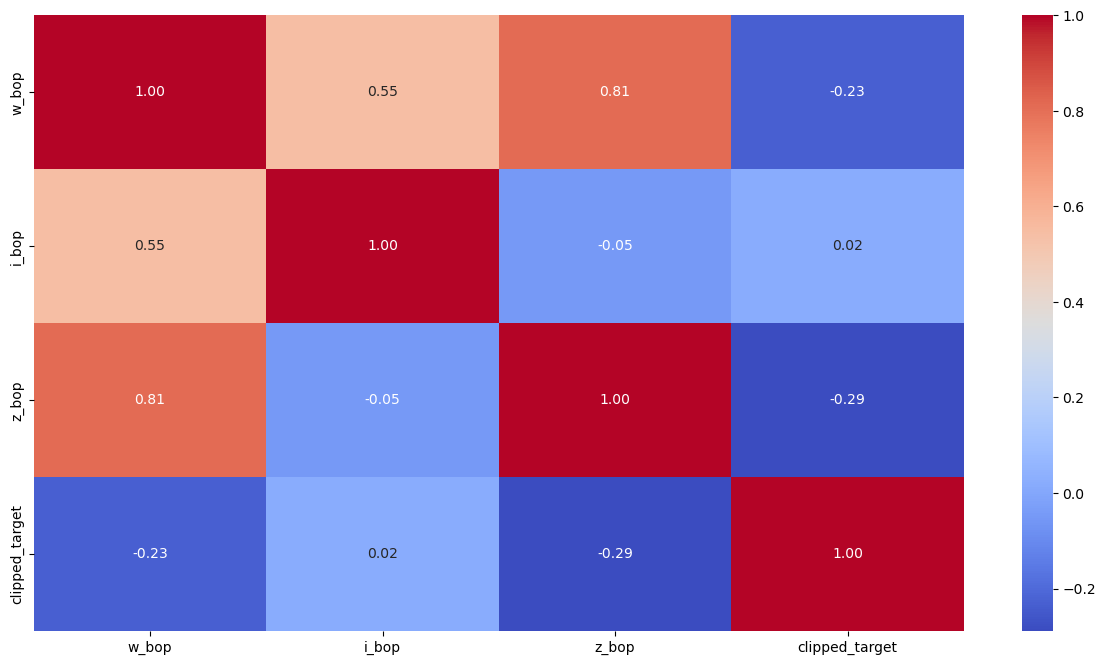

In [39]:
plot_heatmap(
    train[get_cols(train, contains=["bop"]) + ["clipped_target"]].corr(),
    annot=True,
    fmt=".2f"
)

## Ease of Movement (EMV) - long time to run

not sure need to log the volume or not

In [43]:
def calc_intraday_emv(df, size_cols = ["matched_size", "bid_size", "ask_size", "imb_size"], verbose = 0):
    if verbose:
        cprint(f"Generating EMV related features for column...", color="green")   
        
    grouped_df = df.groupby(['stock_id', 'date_id'])


    # Iterate over the groups
    for name, group in tqdm(grouped_df):
        # Calculate Distance Moved
        group['emv_distance_moved'] = (group['ask_price'] + group['bid_price']) / 2 - (group['ask_price'].shift(1) + group['bid_price'].shift(1)) / 2
            
        for size in size_cols:
            # Calculate Box Ratio
            group[f'{size}_box_ratio'] = group[size] / (group['bid_price'] - df['ask_price'])

            # Calculate Ease of Movement (EMV)
            group[f'{size}_emv'] =  group['emv_distance_moved'] / group[f'{size}_box_ratio']
            
        df.loc[group.index, f'{size}_emv'] = group[f'{size}_emv']
    return df

In [44]:
%%time
print(train.shape)
train = calc_intraday_emv(train,  size_cols = ["matched_size"])
print(train.shape)

(2647755, 189)


  0%|▎                                                                           | 191/48141 [01:34<6:37:24,  2.01it/s]


KeyboardInterrupt: 

In [ ]:
plot_heatmap(
    train[get_cols(train, contains=["emv"]) + ["clipped_target"]].corr(),
    annot=True,
    fmt=".2f"
)

## Stochastic Oscillators (STO)

In [40]:
def calc_intraday_sto(df, price_cols=["wa_price", "index_price", "z_price"],windows = [3, 6, 9, 12], verbose = 0):
    if verbose:
        cprint(f"Generating SO related features for column...", color="green")   
        
    # Calculate the displaced moving average
    for price_col in tqdm(price_cols, disable= not verbose):
        for window in windows:
            # Calculate the lowest low and highest high within the specified 'stoch_window'
            df[f'min_sto{window}'] = df.groupby(['stock_id','date_id'])['bid_price'].rolling(window).min().values
            df[f'max_sto{window}'] = df.groupby(['stock_id','date_id'])['ask_price'].rolling(window).max().values

            # Calculate the stochastic oscillators
            df[f'{price_col[0]}_sto{window}'] = ((df[price_col] - df[f'min_sto{window}']) / (df[f'max_sto{window}'] - df[f'min_sto{window}'])) * 100

        # Drop the temporary columns used for rolling calculations
        #df = df.drop(['rolling_low', 'rolling_high'], axis=1)

    return df

In [41]:
%%time
print(train.shape)
train = calc_intraday_sto(train)
print(train.shape)

(2647755, 169)
(2647755, 189)
CPU times: total: 1min 46s
Wall time: 2min 22s


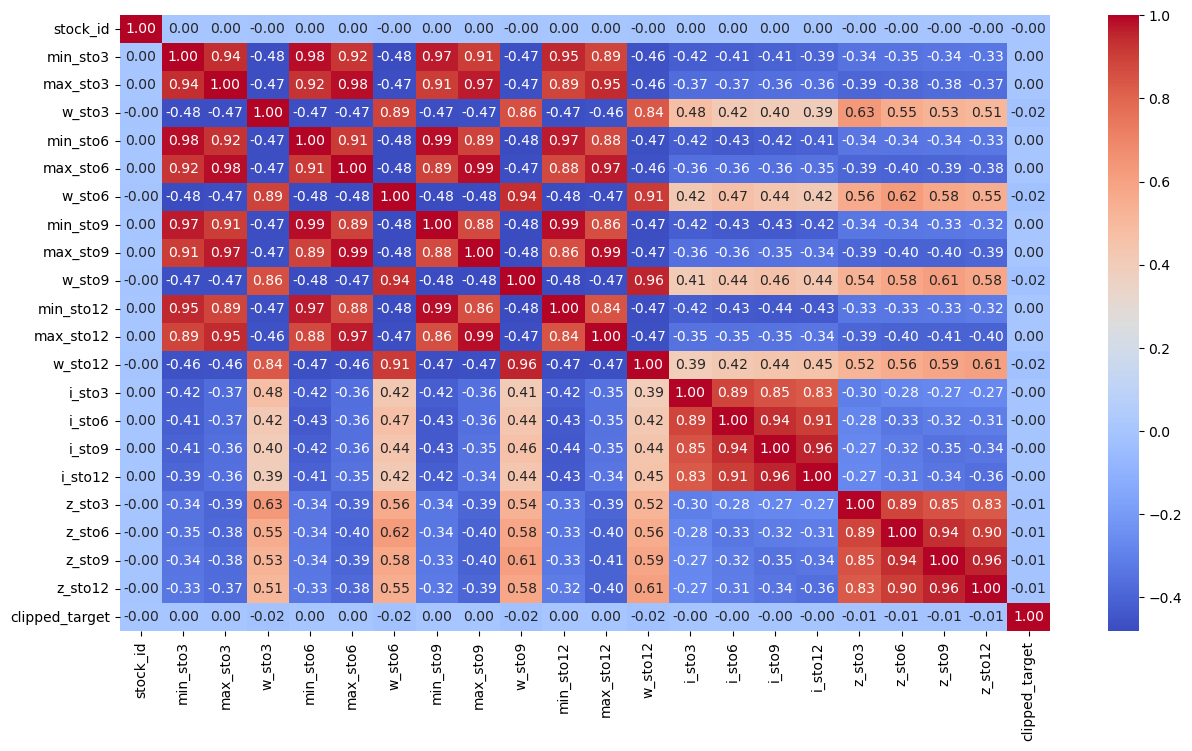

In [42]:
plot_heatmap(
    train[get_cols(train, contains=["sto"]) + ["clipped_target"]].corr(),
    annot=True,
    fmt=".2f"
)

## Triple Exponential Moving Average

In [45]:
def calc_intraday_tema(df, price_cols=["wa_price", "index_price", "z_price"], windows = [3, 6, 9, 12], verbose = 0):
    
    if verbose:
        cprint(f"Generating DPO related features for column...", color="green")    
    # Calculate the displaced moving average
    for price_col in tqdm(price_cols, disable= not verbose):
        for window in windows: 
            # Calculate the first EMA
            df[f'{price_col}_ema1'] = df.groupby(['stock_id','date_id'])[price_col].ewm(span=window, adjust=False).mean().values

            # Calculate the second EMA
            df[f'{price_col}_ema2'] = df.groupby(['stock_id','date_id'])[f'{price_col}_ema1'].ewm(span=window, adjust=False).mean().values

            # Calculate the third EMA
            df[f'{price_col}_ema3'] = df.groupby(['stock_id','date_id'])[f'{price_col}_ema2'].ewm(span=window, adjust=False).mean().values

            # Calculate TEMA
            df[f'{price_col}_tema'] = 3 * df[f'{price_col}_ema1'] - 3 * df[f'{price_col}_ema2']  + df[f'{price_col}_ema3']
    return df

In [46]:
%%time
print(train.shape)
train = calc_intraday_tema(train)
print(train.shape)

(2647755, 190)
(2647755, 202)
CPU times: total: 1min 30s
Wall time: 1min 57s


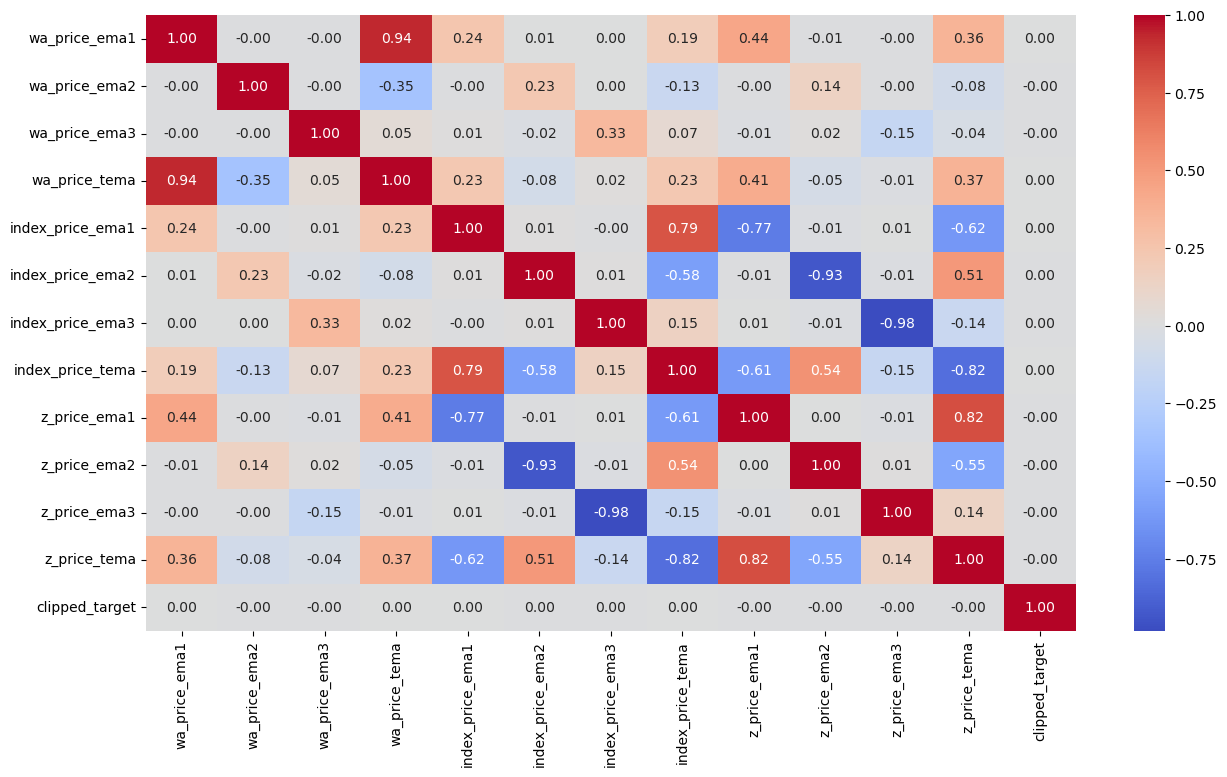

In [47]:
plot_heatmap(
    train[get_cols(train, contains=["ema"]) + ["clipped_target"]].corr(),
    annot=True,
    fmt=".2f"
)

## Coppock Curve (CoC)

In [50]:
def calc_intraday_coc(df, price_cols=["wa_price", "index_price", "z_price"], 
                      roc_period = 12, wma_period=10, verbose = 0):

    if verbose:
        cprint(f"Generating COC related features for column...", color="green") 
        
    for price_col in tqdm(price_cols, disable= not verbose):
        # Group by 'stock_id' and 'date_id'
        grouped_df = df.groupby(['stock_id', 'date_id'])
        
        # Iterate over the groups
        for name, group in tqdm(grouped_df):
            # Calculate Rate of Change (ROC)
            group[f'{price_col}_roc'] = (group[price_col] - group[price_col].shift(roc_period)) / group[price_col].shift(roc_period)

            # Calculate Weighted Moving Average (WMA)
            group[f'{price_col}_coc'] = group[f'{price_col}_roc'].rolling(window=wma_period).mean()

            # Update the original DataFrame with the calculated coc values for the current group
            df.loc[group.index, f'{price_col}_coc'] = group[f'{price_col}_coc']

    return df

In [51]:
%%time
print(train.shape)
train = calc_intraday_coc(train)
print(train.shape)

(2647755, 204)


100%|███████████████████████████████████████████████████████████████████████████| 48141/48141 [03:30<00:00, 229.16it/s]


(2647755, 205)
CPU times: total: 4min 27s
Wall time: 9min 42s


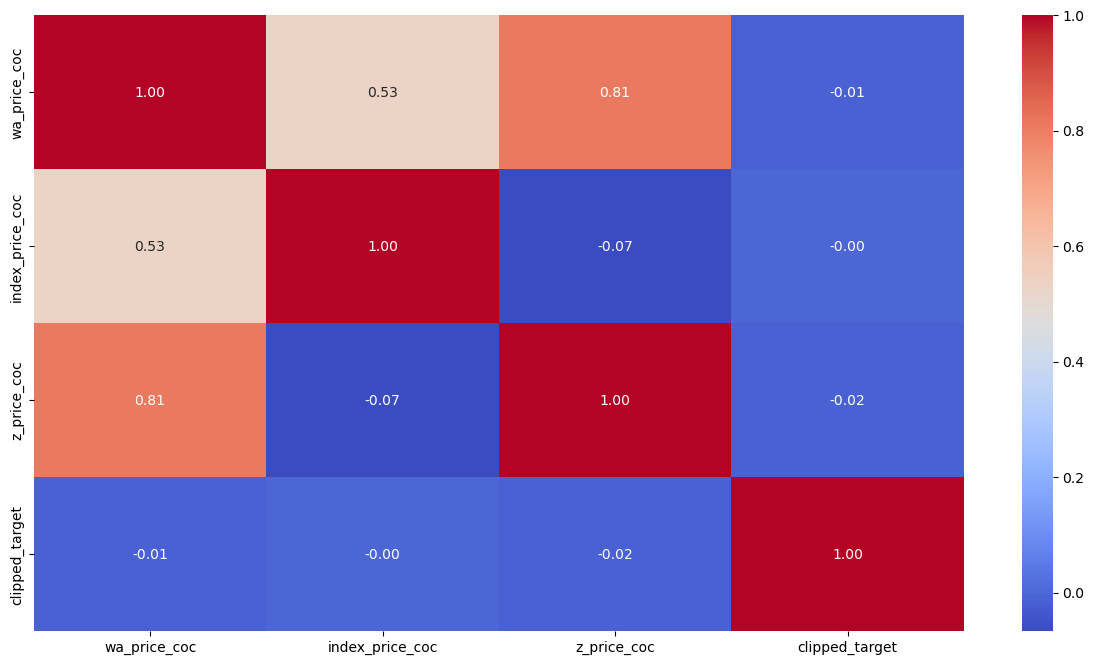

In [52]:
plot_heatmap(
    train[get_cols(train, contains=["coc"]) + ["clipped_target"]].corr(),
    annot=True,
    fmt=".2f"
)

## Gator Oscillator (gos)

In [56]:
def calc_intraday_gos(df, price_cols=["bid_price","ask_price","wa_price", "index_price", "z_price"], 
                      jaw_period=13, teeth_period=8, lips_period=5,  verbose = 0):
    
  
    if verbose:
        cprint(f"Generating GOS related features for column...", color="green")   
        
    for price_col in tqdm(price_cols, disable= not verbose):
        # Calculate the Jaw (Blue Line)
        df[f'{price_col[0]}_jaw'] = df.groupby(['stock_id','date_id'])[price_col].rolling(window=jaw_period).mean().values

        # Calculate the Teeth (Red Line)
        df[f'{price_col[0]}_teeth'] = df.groupby(['stock_id','date_id'])[price_col].rolling(window=teeth_period).mean().values

        # Calculate the Gator Oscillator
        df[f'{price_col[0]}_gos'] = df[f'{price_col[0]}_jaw'] - df[f'{price_col[0]}_teeth']

    return df

In [57]:
%%time
print(train.shape)
train = calc_intraday_gos(train)
print(train.shape)

(2647755, 206)
(2647755, 220)
CPU times: total: 36.1 s
Wall time: 58.1 s


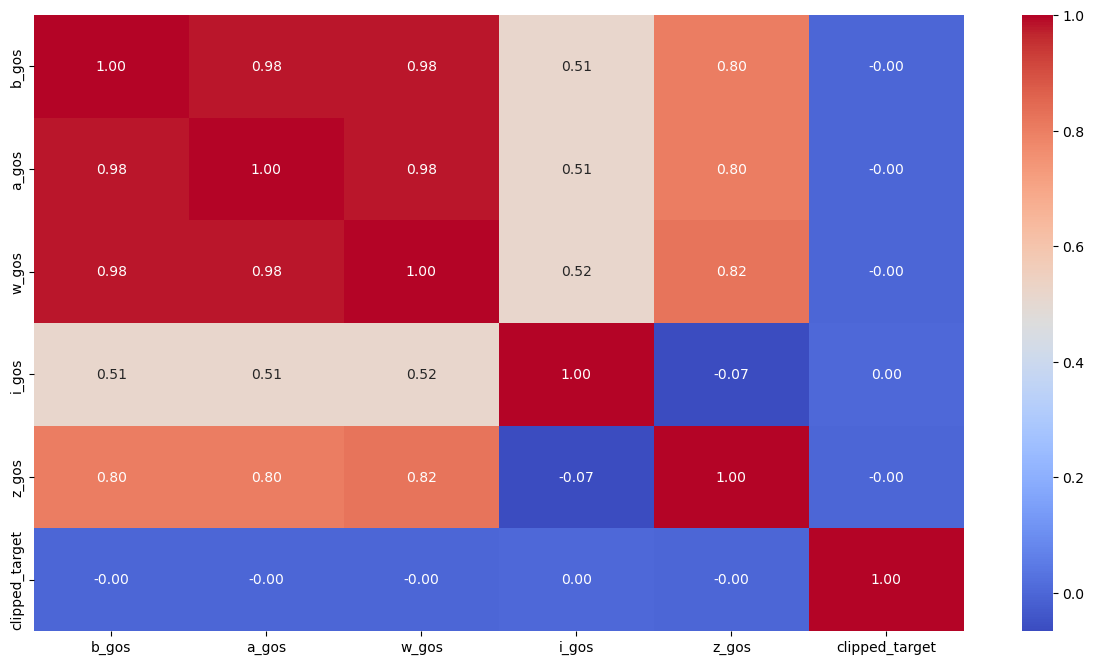

In [58]:
plot_heatmap(
    train[get_cols(train, contains=["gos"]) + ["clipped_target"]].corr(),
    annot=True,
    fmt=".2f"
)

## Pivot Points

In [67]:
def calc_pivot_points(df):
    # Calculate Pivot Point (PP)
    df['pivot_point_ppt'] = (df['bid_price'] + df['ask_price'] + df['wa_price']) / 3

    # Calculate Support and Resistance Levels
    df['support1_ppt'] = 2 * df['pivot_point_ppt'] - df['ask_price']
    df['resistance1_ppt'] = 2 * df['pivot_point_ppt'] - df['bid_price']
    df['support2_ppt'] = df['pivot_point_ppt'] - (df['ask_price'] - df['bid_price'])
    df['resistance2_ppt'] = df['pivot_point_ppt'] + (df['ask_price'] - df['bid_price'])
    df['support3_ppt'] = df['ask_price'] - 2 * (df['ask_price'] - df['pivot_point_ppt'])
    df['resistance3_ppt'] = df['ask_price'] + 2 * (df['pivot_point_ppt'] - df['bid_price'])

    return df

In [68]:
%%time
print(train.shape)
train = calc_pivot_points(train)
print(train.shape)

(2647755, 228)
(2647755, 234)
CPU times: total: 109 ms
Wall time: 295 ms


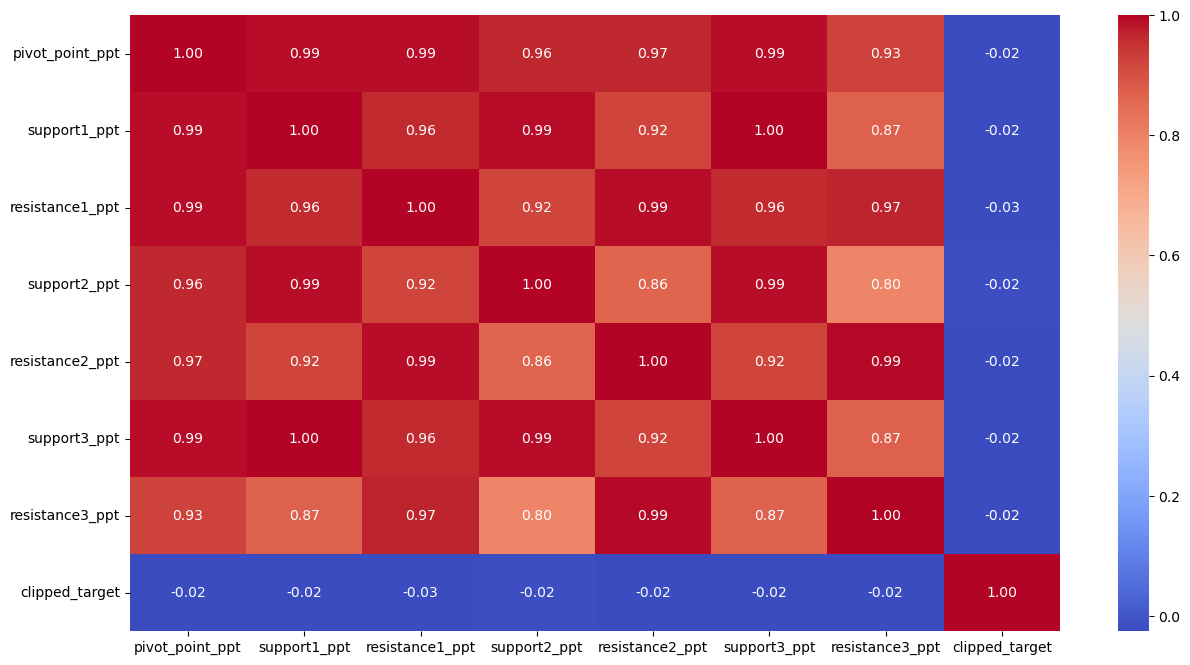

In [69]:
plot_heatmap(
    train[get_cols(train, contains=["ppt"]) + ["clipped_target"]].corr(),
    annot=True,
    fmt=".2f"
)

## Williams Fractal (WIF)

In [72]:
import pandas as pd

def calc_intraday_wif(df, windows = [3, 5, 6, 9, 10], verbose = 0):
    if verbose:
        cprint(f"Generating WIF related features for column...", color="green")   
        

    # Calculate the ask_price and bid_price of the last 5 bars
    for window in tqdm(windows):
        df[f'max_{window}'] = df.groupby(['stock_id','date_id'])['ask_price'].rolling(window=window, center=True).max().values
        df[f'min_{window}'] = df.groupby(['stock_id','date_id'])['bid_price'].rolling(window=window, center=True).min().values

        # Identify bullish fractals (bid_priceest bid_price in the middle)
        df[f'bullish_fractal_{window}'] = (df['bid_price'] == df[f'min_{window}']) & (df['bid_price'].shift(1) > df['bid_price']) & (df['bid_price'].shift(2) > df['bid_price']) & (df['bid_price'].shift(3) < df['bid_price']) & (df['bid_price'].shift(4) < df['bid_price'])

        # Identify bearish fractals (ask_priceest ask_price in the middle)
        df[f'bearish_fractal_{window}'] = (df['ask_price'] == df[f'max_{window}']) & (df['ask_price'].shift(1) < df['ask_price']) & (df['ask_price'].shift(2) < df['ask_price']) & (df['ask_price'].shift(3) > df['ask_price']) & (df['ask_price'].shift(4) > df['ask_price'])

        # Drop temporary columns
        df.drop([f'max_{window}', f'min_{window}'], axis=1, inplace=True)

    return df

In [73]:
%%time
print(train.shape)
train = calc_intraday_wif(train)
print(train.shape)

(2647755, 236)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:32<00:00, 18.54s/it]

(2647755, 244)
CPU times: total: 44.4 s
Wall time: 1min 32s


In [ ]:
plot_heatmap(
    train[get_cols(train, contains=["wif"]) + ["clipped_target"]].corr(),
    annot=True,
    fmt=".2f"
)

## Normalized Features

### On-Balance Volume

In [ ]:
# On-Balance Volume
def calc_intraday_on_balance_volume(df, price_cols, volume_cols, verbose=0):    
    # Group the DataFrame by 'stock_id' and 'date_id'
    grouped = df.groupby(['stock_id', 'date_id'])

    for price in tqdm(price_cols, disable=not verbose):
        for volume in volume_cols:
            # Calculate the price change for each group
            df['price_change'] = grouped[price].diff()

            # Initialize the direction for each group
            df['direction'] = 0

            # Set the direction based on price changes
            df.loc[df['price_change'] > 0, 'direction'] = 1
            df.loc[df['price_change'] < 0, 'direction'] = -1

            # Calculate the OBV for each group
            df[f'{price}_{volume}_obv'] = (df['direction'] * df[volume]).cumsum()

    # Drop the temporary columns for each group
    df.drop(columns=['price_change', 'direction'], inplace=True)
    
    return df

In [ ]:
%%time
print(train.shape)
train = calc_intraday_on_balance_volume(train, price_cols=["wa_price", "ask_price", "bid_price", "ref_price"], volume_cols=['matched_size'])
print(train.shape)

In [ ]:
%%time
corr_df = train.loc[:, ["wa_price", "ask_price", "bid_price"] + train.columns[-4:].tolist() + ["target"]].corr()
plot_heatmap(
    corr_df,
    annot=True,
    fmt=".2f"
)

# Interday (Temporal) Features 

## Stock-Date Level Features
- GroupBy (Stock ID) then calculate past N days statistics
- Merge By (Stock ID, Date ID)

### Prepare Master Reference Data
- To prepare the master dataframe for us to continue append when submitting via Kaggle kernel for test data
- Potentially can drop the rows which is too long ago (if we are just interested in past N days, then lag N + 1 can be throw like a queue to reduce memory)

In [ ]:
def get_master_daily_data(master_df, base_price_columns,  missing_stock_dates=None, 
                          groupby=["stock_id", "date_id"], 
                          ba_volume_columns=["c_size"], 
                          im_size_columns=["imb_size", "matched_size"], verbose=0):
    # Sort the dataframe first
    master_df = master_df.sort_values(by=META_COLUMNS).reset_index(drop=True)
    
    # Get all volume columns together
    base_volume_columns = ba_volume_columns + im_size_columns
    
    # Base Daily Agg Features
    master_daily_data = []
    for round_, seconds_period in tqdm(enumerate([(0, 540)]), disable=not verbose):
        # Filter dataframe
        master_subset = filter_df(master_df, seconds=seconds_period)
        
        if round_ < 2:
            # Compute the last price for every day
            daily_last = master_subset.groupby(["stock_id", "date_id"])[base_price_columns].agg(["last"])
            daily_last.columns = daily_last.columns.map(f'_r{round_}_'.join)
        
        # Calc the gradients for the intraday array
        daily_grads = []
        for c in base_volume_columns:
            temp_grads = master_subset.groupby(
                ["stock_id", "date_id"]
            )[c].apply(calc_intraday_gradient).rename(f"{c}_r{round_}_grad")
            daily_grads.append(temp_grads)
        daily_grads = pd.concat(daily_grads, axis=1)
        
        # Compute the agg statistics of target variable for every day
        daily_median = master_subset.groupby(
            ["stock_id", "date_id"]
        )[ba_volume_columns].agg([percentile(.25), "median", percentile(.75)])
        daily_median.columns = daily_median.columns.map(f'_r{round_}_'.join)
        
        daily_mean = master_subset.groupby(
            ["stock_id", "date_id"]
        )[im_size_columns].agg(["mean", "std"])
        daily_mean.columns = daily_mean.columns.map(f'_r{round_}_'.join)
        
        # Horizontally stack all the dataframes above
        daily_data = pd.concat([daily_grads, daily_median, daily_mean, daily_last], axis=1)
        daily_data = downcast_to_32bit(daily_data, verbose=0)
        
        # Append this dataframe for this master df subset into list
        master_daily_data.append(daily_data)
        
    master_daily_data = pd.concat(master_daily_data, axis=1)
    
    # Fill in the missing entries
    if missing_stock_dates is not None:
        master_daily_data = master_daily_data.reset_index()
        for stock_id, date_id in missing_stock_dates:
            date_id = date_id[0]
            missing_row = filter_df(master_daily_data, stock_id=stock_id, date_id=date_id)
            row_before_and_after = filter_df(master_daily_data, stock_id=stock_id, date_id=(date_id - 1, date_id + 1))
            if missing_row.shape[0] == 0 and row_before_and_after.shape[0] == 2:
                master_daily_data.loc[master_daily_data.shape[0]] = (
                    row_before_and_after.mean(axis=0)
                )

    # Sort the imputed rows to above, and cast back meta columns to integer and set them as index
    master_daily_data = master_daily_data.sort_values(by=groupby).reset_index(drop=True)
    master_daily_data[groupby] = master_daily_data[groupby].astype(np.int32)
    master_daily_data = master_daily_data.set_index(groupby)
    
    return master_daily_data

In [ ]:
%%time
master_daily_data = get_master_daily_data(train, base_price_columns=base_price_cols, missing_stock_dates=missing_stock_dates)

In [ ]:
%%time
master_daily_data.to_parquet(f"{DATA_DIR}/optiver-support-data/master_daily_data_v2.parquet")

### Generate Features
- This will be the processing script to generate features from the master reference dataframe

In [ ]:
def generate_interday_features(df, master_daily_data, verbose=0):
    full_columns = master_daily_data.columns.tolist()
    master_daily_features = master_daily_data.copy()
    
    # Generate features for intraday gradient columns
    master_daily_features = calc_diff_features(
        master_daily_features, columns=full_columns, groupby=["stock_id"], lag_distances=[1]
    )
    master_daily_features = calc_ma_features(
        master_daily_features, columns=full_columns, groupby=["stock_id"], window_sizes=[3]
    )
    
    # Generate interday gradient features for last price columns
    special_columns = [col for col in full_columns if col.endswith(("_mean", "_last"))]
    master_daily_features = calc_interday_gradient_features(
        master_daily_features, special_columns, groupby=["stock_id"], lookback_periods=[5], verbose=verbose
    )
    
    # Increment date by 1
    master_daily_features = increment_date_id(master_daily_features)
    
    df = df.merge(master_daily_features, left_on=["stock_id", "date_id"], right_index=True, how="left")
    return df

In [ ]:
%%time
print(train.shape)
train = generate_interday_features(train, master_daily_data)
print(train.shape)

## Stock-Date Leaked Target Features
- GroupBy (Stock ID) then calculate past N days target value statistics
- Merge By (Stock ID, Date ID)

### Prepare Master Reference Data
- To prepare the master dataframe for us to continue append when submitting via Kaggle kernel for test data
- Potentially can drop the rows which is too long ago (if we are just interested in past N days, then lag N + 1 can be throw like a queue to reduce memory)

In [ ]:
def get_master_daily_target_data(master_df, missing_stock_dates=None, groupby=["stock_id", "date_id"], verbose=0):
    # Sort the dataframe first
    master_df = master_df.sort_values(by=META_COLUMNS).reset_index(drop=True)
    
    master_daily_target_data = []
    for round_, seconds_period in tqdm(enumerate([(0, 540)]), disable=not verbose):
        # Filter dataframe
        master_subset = filter_df(master_df, seconds=seconds_period)
        
        # # Calc the gradients for the intraday array
        # daily_target_grads = master_subset.groupby(
        #     groupby
        # )["target"].apply(calc_intraday_gradient).apply(pd.Series)
        # daily_target_grads.columns = [f"target_r{round_}_grad"]
        # daily_target_grads.drop(columns=f"target_r{round_}_intercept", errors="ignore", inplace=True)
        
        # Compute the agg statistics of target variable for every day
        daily_target_stats = master_subset.groupby(groupby)["target"].agg(
            ["mean", "std", "min", percentile(.25), "median", percentile(.75), "max", "skew"]
        ).add_prefix(f"daily_target_r{round_}_")
        
        master_subset["target_fod"] = master_subset.groupby(groupby)["target"].diff(1).values
        daily_target_fod_stats = master_subset.groupby(groupby)["target_fod"].agg(
            ["mean", "std", "min", percentile(.25), "median", percentile(.75), "max", "skew"]
        ).add_prefix(f"daily_target_fod_r{round_}_")

        # Horizontally stack all the dataframes above
        daily_target_data = pd.concat([daily_target_stats, daily_target_fod_stats], axis=1)
        daily_target_data = downcast_to_32bit(daily_target_data, verbose=0)
        
        # Append this dataframe for this master df subset into list
        master_daily_target_data.append(daily_target_data)
    
    master_daily_target_data = pd.concat(master_daily_target_data, axis=1)
    master_daily_target_data = master_daily_target_data.reset_index()
    
    # Fill in the missing entries
    if missing_stock_dates is not None:
        for stock_id, date_id in missing_stock_dates:
            date_id = date_id[0]
            missing_row = filter_df(master_daily_target_data, stock_id=stock_id, date_id=date_id)
            row_before_and_after = filter_df(master_daily_target_data, stock_id=stock_id, date_id=(date_id - 1, date_id + 1))
            if missing_row.shape[0] == 0 and row_before_and_after.shape[0] == 2:
                master_daily_target_data.loc[master_daily_target_data.shape[0]] = (
                    row_before_and_after.mean(axis=0)
                )

    # Sort the imputed rows to above, and cast back meta columns to integer and set them as index
    master_daily_target_data = master_daily_target_data.sort_values(by=groupby).reset_index(drop=True)
    master_daily_target_data[groupby] = master_daily_target_data[groupby].astype(np.int32)
    master_daily_target_data = master_daily_target_data.set_index(groupby)
        
    return master_daily_target_data

In [ ]:
%%time
master_daily_target_data = get_master_daily_target_data(train, missing_stock_dates=missing_stock_dates)

In [ ]:
%%time
corr_df_ = master_daily_target_data.corr()
plot_heatmap(
    corr_df_,
    annot=True,
    fmt=".2f"
)

In [ ]:
%%time
master_daily_target_data.to_parquet(f"{DATA_DIR}/optiver-support-data/master_daily_target_data_v2.parquet")

### Generate Features
- This will be the processing script to generate features from the master reference dataframe

In [ ]:
def generate_interday_target_features(df, master_daily_target_data, verbose=0):
    full_columns = master_daily_target_data.columns.tolist()
    master_daily_target_features = master_daily_target_data.copy()
    
    # Generate FOD and MA2 features
    master_daily_target_features = calc_diff_features(
        master_daily_target_features, columns=full_columns, groupby=["stock_id"], lag_distances=[1]
    )
    
    master_daily_target_features = calc_ma_features(
        master_daily_target_features, columns=full_columns, groupby=["stock_id"], window_sizes=[3]
    )
    
    # # Calculate ratio between FOD and MA2
    # master_daily_target_features[[f"{col}_ld1_ma2_ratio" for col in full_columns]] = (
    #     master_daily_target_features[[f"{col}_ld1" for col in full_columns]].values / master_daily_target_features[[f"{col}_ma2" for col in full_columns]].values
    # )
    
    # Generate interday gradient features for last price columns
    special_columns = [col for col in full_columns if col.endswith(("_mean"))]
    master_daily_target_features = calc_interday_gradient_features(
        master_daily_target_features, special_columns, groupby=["stock_id"], lookback_periods=[5], verbose=verbose
    )
    
    # Increment date by 1
    master_daily_target_features = increment_date_id(master_daily_target_features)
    
    df = df.merge(master_daily_target_features, left_on=["stock_id", "date_id"], right_index=True, how="left")
    df = downcast_to_32bit(df, verbose=0)
    return df

In [ ]:
%%time
print(train.shape)
train = generate_interday_target_features(train, master_daily_target_data)
print(train.shape)

## Stock-Date-Seconds Key
- GroupBy (Stock ID, Seconds) then calculate past N days statistics
- Merge By (Stock ID, Date ID, Seconds)

### Prepare Master Reference Data
- To prepare the master dataframe for us to continue append when submitting via Kaggle kernel for test data
- Potentially can drop the rows which is too long ago (if we are just interested in past N days, then lag N + 1 can be throw like a queue to reduce memory)

In [ ]:
def get_master_seconds_data(master_df, base_price_columns, 
                            ba_volume_columns=["bid_size", "ask_size", "ab_size"], 
                            im_size_columns=["imb_size", "matched_size"], 
                            groupby=["stock_id", "seconds"], verbose=0):
    # Sort the dataframe first
    master_df = master_df.sort_values(by=["stock_id", "seconds", "date_id"]).reset_index(drop=True)
    
    # Get all volume columns together
    base_volume_columns = ba_volume_columns + im_size_columns
    
    # Compute the agg statistics of target variable for ticks
    seconds_median = master_df.groupby(groupby)[ba_volume_columns].agg([percentile(.25), "median", percentile(.75)])
    seconds_median.columns = seconds_median.columns.map(f'_seconds_'.join)

    seconds_mean = master_df.groupby(groupby)[base_price_columns + im_size_columns].agg(["mean", "std"])
    seconds_mean.columns = seconds_mean.columns.map(f'_seconds_'.join)

    # Horizontally stack all the dataframes above
    master_seconds_data = pd.concat([seconds_median, seconds_mean], axis=1)
    master_seconds_data = downcast_to_32bit(master_seconds_data, verbose=0)
    
    return master_seconds_data

In [ ]:
# %%time
# master_seconds_data = get_master_seconds_data(train, base_price_columns=base_price_cols)

In [ ]:
# master_seconds_data.to_parquet(f"{DATA_DIR}/optiver-support-data/master_seconds_data_v2.parquet")

**This should be on Date ID basis!!!**

### Generate Features
- This will be the processing script to generate features from the master reference dataframe

In [ ]:
def generate_seconds_features(df, master_seconds_data, verbose=0):
    df = df.merge(master_seconds_data, left_on=["stock_id", "seconds"], right_index=True, how="left")
    df = downcast_to_32bit(df, verbose=0)
    return df

In [ ]:
# %%time
# print(train.shape)
# train = generate_seconds_features(train, master_seconds_data)
# print(train.shape)

## Normalized Features
- Normalize the raw info based on the aggregate info using standard scale or robust scale, this will be the main input to Sequential NN
- Some examples of normalization:
  - Matched size, using Past 14 days matched size Q1, median, Q3; for the same stock
  - Reference price, using past 7 days Reference price mean, std; for the same stock

In [ ]:
def normalized_features(df, verbose=0):
    mean_cols = ['imb_size_r0_mean', 'matched_size_r0_mean', 'imb_size_r0_mean_ma3', 'matched_size_r0_mean_ma3']
    std_cols = ['imb_size_r0_std', 'matched_size_r0_std', 'imb_size_r0_std_ma3', 'matched_size_r0_std_ma3']
    for mean_col, std_col in tqdm(
        zip(
            mean_cols, 
            std_cols
        ),
        disable=not verbose
    ):
        ori_col1 = "_".join(mean_col.split("_")[:2])
        ori_col2 = "_".join(std_col.split("_")[:2])
        if ori_col1 == ori_col2:
            df[f"{ori_col1}_stdsc"] = (df[ori_col1] -  df[mean_col]) / df[std_col]
    
    pct25_cols = ['bid_size_r0_pct25', 'ask_size_r0_pct25', 'ab_size_total_r0_pct25', 'bid_size_r0_pct25_ma3', 'ask_size_r0_pct25_ma3', 'ab_size_total_r0_pct25_ma3']
    median_cols = ['bid_size_r0_median', 'ask_size_r0_median', 'ab_size_total_r0_median', 'bid_size_r0_median_ma3', 'ask_size_r0_median_ma3', 'ab_size_total_r0_median_ma3']
    pct75_cols = ['bid_size_r0_pct75', 'ask_size_r0_pct75', 'ab_size_total_r0_pct75', 'bid_size_r0_pct75_ma3', 'ask_size_r0_pct75_ma3', 'ab_size_total_r0_pct75_ma3']
    for q1_col, q2_col, q3_col in tqdm(
        zip(
            pct25_cols, 
            median_cols, 
            pct75_cols, 
        ),
        disable=not verbose
    ):
        ori_col1 = "_".join(q1_col.split("_")[:2])
        ori_col2 = "_".join(q2_col.split("_")[:2])
        ori_col3 = "_".join(q3_col.split("_")[:2])
        try:
            if ori_col1 == ori_col2 and ori_col2 == ori_col3:
                df[f"{ori_col1}_rbtsc"] = (df[ori_col1] -  df[q2_col]) / (df[q3_col] - df[q1_col])
        except:
            pass
        
    return df

In [ ]:
%%time
print(train.shape)
train = normalized_features(train)
print(train.shape)

# Cross-Sectional Features (Level 2) (ToDo)

- This section is for interaction feature generation on agg features, temporal features, as well as normalized features

In [ ]:
%%time
train = train.sort_values(by=META_COLUMNS).reset_index(drop=True)

In [ ]:
%%time
train_path = f"{DATA_DIR}/optiver-train-data/train_by_batch_gen_v5.parquet"
train.to_parquet(train_path)

# Feature Evaluation (WIP)

In [ ]:
%%time
train = read_data(train_path)

In [ ]:
train.columns

## Chi-Square Log P-value

In [ ]:
# all_logp.to_csv("../features_summary/features_logp_values.csv")
# all_logp.to_parquet("../features_summary/features_logp_values.parquet")

In [ ]:
all_logp = read_data("../features_summary/features_logp_values.parquet")
all_logp_metrics = 0.5 * all_logp.median() + 0.25 * (all_logp.apply(percentile(.25)) + all_logp.apply(percentile(.75)))
all_logp.head()

In [ ]:
cat_model = read_model(f"{DATA_DIR}/optiver-catboost-models/cat_model1.cbm")
cat_imp_df = plot_feature_importance(cat_model.feature_names_, cat_model.get_feature_importance(), return_df=True, plot_chart=False)

In [ ]:
train.min()[train.min() == -np.inf]

In [ ]:
log_chi_square_p_df, log_chi_square_p_metrics = run_chi_square_tests(train, feature_columns=train.columns[-8:])

In [ ]:
all_cols = list_diff(train, all_logp.columns.tolist() + META_COLUMNS + target_columns)

In [ ]:
log_chi_square_p_df, log_chi_square_p_metrics = run_chi_square_tests(train, feature_columns=all_cols)

In [ ]:
aa = get_cols(all_logp, "_cumavg")

In [ ]:
cat_imp_df.loc[cat_imp_df["feature"].isin(aa)][:40]

In [ ]:
all_logp_metrics[aa].sort_values()[:50]

In [ ]:
for col in log_chi_square_p_df.columns:
    all_logp[col] = log_chi_square_p_df[col]

In [ ]:
all_logp

In [ ]:
%%time
new_features = list_diff(cat_imp_df["feature"], all_logp.columns)
log_chi_square_p_df, log_chi_square_p_mean = run_chi_square_tests(train, feature_columns=new_features)

In [ ]:
train.columns[5:10]

In [ ]:
log_chi_square_p_df, log_chi_square_p_median = run_chi_square_tests(train, feature_columns=train.columns[5:10])

In [ ]:
log_chi_square_p_median

In [ ]:
imp_df = imp_df.merge(all_logp.mean().rename("chi_square_avg").reset_index(), left_on="feature", right_on="index", how="left")
imp_df = imp_df.merge(all_logp.median().rename("chi_square_median").reset_index(), left_on="feature", right_on="index", how="left")
imp_df = imp_df.merge(all_logp.max().rename("chi_square_max").reset_index(), left_on="feature", right_on="index", how="left")

In [ ]:
imp_df["log_feature_importance"] = imp_df["feature_importance"].apply(np.log1p)
imp_df["rank_feature_importance"] = imp_df["feature_importance"].rank(method="average", ascending=False)

In [ ]:
plot_heatmap(
    imp_df[["chi_square_avg", "chi_square_median", "chi_square_max", "feature_importance", "log_feature_importance", "rank_feature_importance"]].corr(),
    annot=True
)

In [ ]:
imp_df.loc[(imp_df["rank_feature_importance"] < 100) & (imp_df["chi_square_median"] > -50)]

In [ ]:
train["ask_size_stdsc_"] = (train["ask_size"] - train["ask_size"].mean()) / (train["ask_size"].std())

In [ ]:
train["ask_size_stdsc_"].plot.hist(bins=100)

In [ ]:
temp = filter_df(train, stock_id=0)
temp = temp.loc[temp["is_mild_target"] == 0]

In [ ]:
temp_imp_df = imp_df.loc[imp_df["feature"].str.contains("imb_ratio")]

In [ ]:
temp_imp_df["group"] = temp_imp_df["feature"].str[:3]

In [ ]:
temp_imp_df["group2"] = temp_imp_df["feature"].str[4:]

In [ ]:
plot_heatmap(
    pd.pivot_table(temp_imp_df, index="group", columns="group2", values="feature_importance"),
    annot=True
)

In [ ]:
plot_heatmap(
    pd.pivot_table(temp_imp_df, index="group", columns="group2", values="chi_square_median"),
    annot=True
)

In [ ]:
plot_scatterplot(imp_df, x_col="chi_square_median", y_col="rank_feature_importance", ticksize=14)

In [ ]:
log_chi_square_p_df = log_chi_square_p_df.fillna(-745)

In [ ]:
all_logp = all_logp.set_index("stock_id")

In [ ]:
feature_logp[get_cols(all_logp, endswith="log_gt_ratio")].sort_index()

In [ ]:
feature_logp[get_cols(all_logp, endswith="st_ratio", excludes=["gm", "price", "log", "fod"])].sort_index()

In [ ]:
feature_logp[get_cols(all_logp, endswith="gt_ratio", excludes=["gm", "price", "log", "fod"])].sort_index()

In [ ]:
plt.figure(figsize=(19, 15))
all_logp_metrics = 0.5 * all_logp.median() + 0.25 * (all_logp.apply(percentile(.25)) + all_logp.apply(percentile(.75)))
all_logp_metrics.sort_values()[:30][::-1].plot.barh()
plt.show()

In [ ]:
log_chi_square_p_df

In [ ]:
log_chi_square_p_df["stock_id"] = range(200)

In [ ]:
log_chi_square_p_df = log_chi_square_p_df.set_index("stock_id")

In [ ]:
all_logp = pd.concat([all_logp, log_chi_square_p_df], axis=1)

In [ ]:
all_logp.isnull().sum().sort_values()[::-1][:30]

In [ ]:
log_chi_square_p_df

In [ ]:
%%time
run_chi_square_tests(train, feature_columns=list_diff(train.columns, META_COLUMNS + target))

In [ ]:
logp = read_data("../feature_logp_values.csv")
logp2 = read_data("../feature_logp_values2.csv")
logp3 = read_data("../feature_logp_values3.csv")
logp4 = read_data("../feature_logp_values4.csv")
all_logp = pd.concat([logp, logp2, logp3, logp4], axis=1)
# all_logp = all_logp.replace(-np.inf, np.nan)
# all_logp_mean = all_logp.mean().clip(-384, 0).sort_values()[::-1]

In [ ]:
all_logp = all_logp.drop(columns=target_columns)

In [ ]:
all_logp = all_logp.loc[:, META_COLUMNS + sorted(list_diff(all_logp.columns, META_COLUMNS))]

In [ ]:
all_logp["stock_id"] = range(200)

In [ ]:
all_logp = all_logp.set_index("stock_id")

In [ ]:
all_logp = downcast_to_32bit(all_logp)

In [ ]:
all_logp = all_logp.loc[:, META_COLUMNS + get_cols(all_logp, excludes=["seconds"])[2:]]

In [ ]:
all_logp.mean().sort_values()[:50]

In [ ]:
len(set(all_logp.columns))

In [ ]:
# all_logp_mean = all_logp_mean[all_logp_mean.index.isin(train.columns)]

In [ ]:
plt.figure(figsize=(19, 150))
all_logp_mean.plot.barh()
plt.show()

In [ ]:
# TOP_N = 50
# important_columns = all_logp_mean[::-1][2:TOP_N].reset_index()
# important_columns["group"] = pd.Series(important_columns["index"]).str.split("_").apply(lambda x: "_".join(x[1:]) if len(x) > 1 else x)
# important_columns = important_columns.groupby("group")["index"].apply(list)
# important_columns

In [ ]:
# %%time
# log_chi_square_p_df, log_chi_square_p_mean = run_chi_square_tests(train, feature_columns=new_columns)
# log_chi_square_p_df.to_csv("../feature_logp_values5.csv", index=False)

## Variance Inflation Factor (VIF)

## Get Feature Summary & Plot Feature Cluster

In [ ]:
# def plot_clustering_dendogram(linkage_matrix, distance_df):
#     fig, ax = plt.subplots(figsize=(19, 25))
#     dendrogram = sch.dendrogram(linkage_matrix, labels=distance_df.index, orientation='right')
#     plt.xlabel('Correlation Distance')
#     plt.title('Hierarchical Clustering Dendrogram')
#     plt.show()

In [ ]:
# %%time
# feature_summary, feature_corr_df, feature_linkage_matrix = get_feature_summary(lgbm_model, train.sample(523798), clustering_threshold=1.5)
# plot_clustering_dendogram(feature_linkage_matrix, feature_corr_df)

# Test Submission Mode
- Try using the mimic iter test env to generate features for date ID 478 - 480, it should be tally with the one from batch generation

## Loop Feature Generation Script

In [ ]:
def retrieve_date_seconds_and_add_order(test):
    date_id = test["date_id"].unique()[0]
    second = test["seconds_in_bucket"].unique()[0]
    test["order"] = range(test.shape[0])
    return test, date_id, second

In [ ]:
def preprocessing(test):
    test = clean_df(test)
    test = clip_df(test)
    test = generate_price_cross_sectional_features(test, base_price_cols=base_price_cols)
    test = generate_volume_cross_sectional_features(test, base_vol_cols=base_volume_cols)
    test = generate_price_volume_cross_sectional_features(test)
    return test

In [ ]:
def interday_df_setup(raw_train, date_id, max_look_back):
    end_date = date_id - 1
    raw_interday_df = filter_df(raw_train, date_id=(end_date - max_look_back, end_date))
    interday_df = preprocessing(raw_interday_df).sort_values(by=META_COLUMNS).reset_index(drop=True)
    interday_df = interday_df.drop(
        columns=["clipped_target", "is_positive_target", "is_mild_target"],
        errors="ignore"
    )
    master_daily_data = get_master_daily_data(interday_df, base_price_columns=base_price_cols, missing_stock_dates=missing_stock_dates)
    master_daily_target_data = get_master_daily_target_data(interday_df, missing_stock_dates=missing_stock_dates)
    return interday_df, master_daily_data, master_daily_target_data

In [ ]:
def process_revealed_targets(raw_intraday_df, revealed_targets):
    revealed_targets = revealed_targets.drop(columns=["date_id", "revealed_time_id"], errors="ignore")
    revealed_targets = revealed_targets.rename(
        columns={"revealed_target": "target", "revealed_date_id": "date_id", "seconds_in_bucket": "seconds"}
    )
    revealed_targets[META_COLUMNS] = revealed_targets[META_COLUMNS].astype(int)
    revealed_targets["target"] = revealed_targets["target"].astype(np.float32)
    raw_intraday_df = raw_intraday_df.merge(revealed_targets, on=META_COLUMNS, how="left")
    return raw_intraday_df

In [ ]:
%%time
# Prepare the data required to run the optiver environment loop simulation
iter_test = joblib.load(f'{DATA_DIR}/optiver-test-data/iter_test_copy.pkl')

base_price_cols = ['ref_price', 'far_price', 'near_price', 'bid_price', 'ask_price', 'wa_price']
base_volume_cols = ['imb_size', 'matched_size', 'bid_size', 'ask_size']
base_columns = base_price_cols + base_volume_cols
print(base_columns)

master_daily_data = pd.read_parquet(f"{DATA_DIR}/optiver-support-data/master_daily_data_v1.parquet")
master_daily_target_data = pd.read_parquet(f"{DATA_DIR}/optiver-support-data/master_daily_target_data_v1.parquet")
# master_seconds_data = pd.read_parquet(f"{DATA_DIR}/optiver-support-data/master_seconds_data_v1.parquet")

raw_train = read_data(f"{DATA_DIR}/optiver-trading-at-the-close/train.csv")

In [ ]:
%%time
test_list = []
sample_pred_list = []
MAX_LOOK_BACK = 10
raw_intraday_df = pd.DataFrame()
m_list, m_list2 = [], []
count = 0
for (test, revealed_targets, sample_prediction) in tqdm(iter_test):
    # Get date_id, seconds; insert order column & preprocessing
    test, date_id, second = retrieve_date_seconds_and_add_order(test)
    
    # Preprocess (cleaning, clipping, cross-sectional features generation) test chunk (# of rows == 200)
    p_test = preprocessing(test)
    
    # Setup for first iteration
    if count == 0:
        interday_df, master_daily_data, master_daily_target_data = interday_df_setup(raw_train, date_id=date_id, max_look_back=MAX_LOOK_BACK)
    
    # If this is not the first iteration and second == 0, means we get the full previous day info to build interday features
    elif second == 0:
        # At this moment, the intraday df has the full 0 - 540 seconds data for the previous day
        raw_intraday_df = raw_intraday_df.drop(columns="order", errors="ignore")
        raw_intraday_df = process_revealed_targets(raw_intraday_df, revealed_targets)
        interday_df = pd.concat([interday_df, raw_intraday_df])
        interday_df = interday_df.loc[
            interday_df["date_id"] > interday_df["date_id"].min()
        ].sort_values(META_COLUMNS).reset_index(drop=True)

        # Update master daily data
        temp = get_master_daily_data(interday_df, base_price_columns=base_price_cols, missing_stock_dates=missing_stock_dates)
        master_daily_data = pd.concat([
            master_daily_data.reset_index(),
            filter_df(temp.reset_index(), date_id=date_id - 1)
        ])
        master_daily_data = master_daily_data.loc[
            master_daily_data["date_id"] > master_daily_data["date_id"].min()
        ].sort_values(by=["stock_id", "date_id"]).set_index(["stock_id", "date_id"])
        
        # Update master daily target data
        temp = get_master_daily_target_data(interday_df, missing_stock_dates=missing_stock_dates)
        master_daily_target_data = pd.concat([
            master_daily_target_data.reset_index(),
            filter_df(temp.reset_index(), date_id=date_id - 1)
        ])
        master_daily_target_data = master_daily_target_data.loc[
            master_daily_target_data["date_id"] > master_daily_target_data["date_id"].min()
        ].sort_values(by=["stock_id", "date_id"]).set_index(["stock_id", "date_id"])

        # Reset intraday df
        raw_intraday_df = pd.DataFrame()
        
    raw_intraday_df = pd.concat([raw_intraday_df, p_test], ignore_index=True)
    intraday_df = raw_intraday_df.sort_values(by=META_COLUMNS).reset_index(drop=True)
    
    intraday_df = generate_intraday_leaked_target_features(intraday_df, weight_df, verbose=1)
    intraday_df = generate_fod_columns(intraday_df, fod_column_list=[base_price_cols, base_volume_cols], verbose=0)
    intraday_df = generate_roc_columns(intraday_df, columns=base_columns + ["wwap"], verbose=0)
    intraday_df = generate_interday_target_features(intraday_df, master_daily_target_data)
    intraday_df = generate_interday_features(intraday_df, master_daily_data)
    # intraday_df = generate_seconds_features(intraday_df, master_seconds_data)
    intraday_df = normalized_features(intraday_df)
    intraday_df[META_COLUMNS] = intraday_df[META_COLUMNS].astype(int)
    
    last_tick_df = intraday_df.loc[
        (intraday_df["seconds"] == int(second)) & (intraday_df["date_id"] == int(date_id))
    ].sort_values(by="order").drop(columns="order").reset_index(drop=True)
    test_list.append(last_tick_df)
    
    # sample_prediction['target'] = (
    #     lgbm_model6.predict(last_tick_df.loc[:, lgbm_model6.feature_name()])
    # )
    # sample_prediction['target'] = sample_prediction['target'].fillna(0).clip(-50, 50)
    
#     # Adjust our prediction using this function, actually I don't know what is its function
#     sample_prediction['target'] = zero_sum(
#         sample_prediction['target'], 
#         a['bid_size'] + a['ask_size']
#     )
    
    # sample_pred_list.append(sample_prediction)
    # if SUBMIT or date_id > 480:
    #     # Need to call this env.predict to update / submit our prediction
    #     env.predict(sample_prediction)
        
    count += 1

## Check difference between batch generation & loop generation

In [ ]:
%%time
# Read back the final data (features) I have generated using the batch method for Date ID: 0 - 480 (Much faster than loop, so we will use this method for feature generation)
train = read_data("../train_by_batch_gen.parquet")
batch_gen_data = filter_df(train, date_id=(478, 480), reset_index=True)
batch_gen_data.shape

In [ ]:
# test_list = read_data(f"{DATA_DIR}/optiver-test-data/test_list.pkl") # <= This is exported from Kaggle, we can generate in local using previous section's script as well

In [ ]:
# Concat the cache features generated via loop simulation (for Date ID: 477 - 480)
loop_gen_data = my_concat(test_list, reset_index=True)
loop_gen_data.shape

In [ ]:
# The difference should only be the target-related columns, since we are not getting this piece of info during the loop simulation
diff_columns = list_diff(batch_gen_data.columns, loop_gen_data.columns)
diff_columns

In [ ]:
# Prepare both datasets so that they have same format to be comparable
batch_gen_data = batch_gen_data.drop(columns=diff_columns, errors="ignore")
batch_gen_data = batch_gen_data.sort_values(by=META_COLUMNS).reset_index(drop=True)

loop_gen_data = loop_gen_data.reindex(columns=batch_gen_data.columns).sort_values(by=META_COLUMNS).reset_index(drop=True)
loop_gen_data = loop_gen_data.sort_values(by=META_COLUMNS).reset_index(drop=True)
batch_gen_data.shape, loop_gen_data.shape

In [ ]:
batch_gen_data.tail(10)

In [ ]:
loop_gen_data.tail(10)

In [ ]:
for col in loop_gen_data.columns:
    if batch_gen_data[col].isnull().sum() != loop_gen_data[col].isnull().sum():
        cprint(f"Column {col}, has different null value count", color="green")
        
    abs_diff = (batch_gen_data[col] - loop_gen_data[col]).dropna().abs().max()
    if abs_diff > 0.01 or abs_diff != abs_diff:
        not_tally_proportion = (abs_diff > 0.01).sum() / loop_gen_data.shape[0]
        cprint(f"Column {col}, has different value, with a abs max of about {abs_diff:.4f}", color="blue", end="\t")
        cprint(f"Not tally proportion {not_tally_proportion:.5f}", color="green")

- Still gt not tally proportion... and I still dunno why actually, I thought it was caused by clipping, but I have aldy removed clipping T.T
- Nvm move on first since the not-tally proportion is less also

# Feature Ideas

## Old Features that belum put in

In [ ]:
# df["log_imb_matched_size_ratio"] = df["log_imb_size"] / df["log_matched_size"]
# df["sqrt_imb_matched_size_ratio"] = my_power(df["imb_size"] / df["matched_size"], 1/2)
# df["sqrt_abs_imb_matched_size_ratio"] = my_power(df["abs_imb_size"] / df["matched_size"], 1/2)
# df["log_bid_matched_size_ratio"] = df["log_bid_size"] / df["log_matched_size"]
# df["log_ask_matched_size_ratio"] = df["log_ask_size"] / df["log_matched_size"]
# df["log_bid_ask_diff_abs_imb_product"] = my_log(df["bid_ask_size_diff"] * df["abs_imb_size"])

In [ ]:
# if verbose:
#     cprint(f"{get_time_now()} Getting Price-Volume Interaction Features...", color="green")


## New Features that pending implementation

In [ ]:
df["imbalance_momentum"] = df.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / df['matched_size']
df["spread_intensity"] = df.groupby(['stock_id'])['price_spread'].diff()
df['price_pressure'] = df['imbalance_size'] * (df['ask_price'] - df['bid_price'])
df['market_urgency'] = df['price_spread'] * df['liquidity_imbalance']
df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])

In [ ]:
delta = train.groupby(['stock_id', 'date_id'])['wa_price'].pct_change()

In [ ]:
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

In [ ]:
train["wa_price_roc"]

In [ ]:

avg_gain

In [ ]:
.describe()

In [ ]:
def calculate_rsi(df, period):

    delta = df.groupby(['stock_id','date_id'])['wap'].pct_change()
    # Calculate the average gain and average loss for the specified period
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()

    # Calculate the Relative Strength (RS) by dividing the average gain by the average loss
    rs = avg_gain / avg_loss

    # Calculate the Relative Strength Index (RSI)
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi
    #Above 70 is overbought, Below 30 is oversold
    df['RSI_signal'] = np.where(df['RSI']> 70, -1, 
                                np.where(df['RSI']<30,1, 0))

    return df

In [ ]:
plot_scatterplot(train, x_col="wa_roc", y_col="target", ticksize=14)

In [ ]:
plot_scatterplot(train, x_col="return_l6", y_col="target", ticksize=14)

In [ ]:
all_logp_metrics[['im_size_gap',
 'bi_size_gap',
 'ai_size_gap',
 'bm_size_gap',
 'am_size_gap',
 'jm_size_gap',
 'ab_size_gap',
 'bj_size_gap',
 'aj_size_gap']]

In [ ]:
train[["ab_size", "matched_size", "imb_size"]]

In [ ]:
spread_columns = get_cols(train, contains="_size_gap")
spread_columns

In [ ]:
# Set the float formatting options
pd.options.display.float_format = lambda x: f"{x:,.5f}"

In [ ]:
# for col in get_cols(train, endswith="_ratio"):
#     print(col)
#     print(np.percentile(train[col].dropna(), 1))
#     print(np.percentile(train[col].dropna(), 99))

In [ ]:
all_logp_metrics["im_gt_ratio"]

In [ ]:
np.percentile(train["im_gt_ratio"], 0.1), np.percentile(train["im_gt_ratio"], 99.9)

In [ ]:
plot_heatmap(
    train[get_cols(train, "_cov")].corr(),
    figsize=(20, 14),
    fmt=".2f",
    annot=True
)